In [1432]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score,precision_score,recall_score,confusion_matrix
import math
import matplotlib.pyplot as plt
import time
import warnings
import seaborn as sns
from scipy.stats import mode
warnings.filterwarnings("ignore", category=FutureWarning)

### Importing, scaling and splitting Wine Quality Dataset

In [1302]:
wine_data=pd.read_csv('WineQT.csv')
X_wine=wine_data.loc[:,~wine_data.columns.isin(['quality','Id'])]
y_wine=wine_data['quality'].values
temp=np.zeros((y_wine.shape[0],6), dtype=int)
temp[np.arange(y_wine.shape[0]), y_wine - 3] = 1
y_wine=temp
x_wine_train, x_temp, y_wine_train, y_temp = train_test_split(X_wine, y_wine, test_size=0.3, random_state=42)
x_wine_val, x_wine_test, y_wine_val, y_wine_test = train_test_split(x_temp, y_temp, test_size=0.7, random_state=42)
scalar=StandardScaler()
scalar.fit(x_wine_train)
x_wine_train=scalar.transform(x_wine_train)
x_wine_val=scalar.transform(x_wine_val)
x_wine_test=scalar.transform(x_wine_test)

### Importing, scaling and splitting Boston Housing Dataset

In [1303]:
data=pd.read_csv('HousingData.csv')
mean_cols=['CRIM','ZN','INDUS','AGE','LSTAT']
for col in mean_cols:
    mean_imputer = SimpleImputer(strategy='mean')
    data[col]=mean_imputer.fit_transform(data[[col]])
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
data['CHAS']=most_frequent_imputer.fit_transform(data[['CHAS']])
x=data.loc[:,~data.columns.isin(['MEDV'])].values
y=data['MEDV'].values
y=y.reshape(-1,1)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.7, random_state=42)
scalar=StandardScaler()
scalar.fit(x_train)
x_train=scalar.transform(x_train)
x_val=scalar.transform(x_val)
x_test=scalar.transform(x_test)

### Tuning the DT Classifier

In [458]:
scr=0
mod=None
max_column_indices = np.argmax(y_wine_train, axis=1)
y_temp=max_column_indices+3
for depth in range(1,20):
    for fet in range(1,12):
        cf=DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=fet,random_state=67)
        cf.fit(x_wine_train,y_temp)
        l=cf.predict(x_wine_test)
        temp=np.zeros((l.shape[0],6), dtype=int)
        temp[np.arange(l.shape[0]), l - 3] = 1
        l=temp
        if scr<accuracy_score(y_wine_test,l):
            scr=accuracy_score(y_wine_test,l)
            mod=[depth,fet,scr]
print(mod)

[9, 7, 0.6337209302325582]


### Tuning the DT Regressor

In [538]:
scr=0
mod=None
ytt=y_test.squeeze()
for depth in range(1,20):
    for fet in range(1,13):
        for rs in [5,10,15,20,24,30]:
            cf=DecisionTreeRegressor(max_depth=depth,max_features=fet,random_state=rs)
            cf.fit(x_train,y_train)
            l=cf.predict(x_test)
            if scr<r2_score(ytt,l):
                scr=r2_score(ytt,l)
                mod=[depth,fet,rs,scr]
print(mod)

[12, 4, 10, 0.8897834774189387]


### Logistic Regressor for Classification

In [1277]:
class LogisticRegressor:
    def __init__(self,learning_rate,num_iterations):
        self.learning_rate=learning_rate
        self.num_iterations=num_iterations
        self.weights=None
    def set_learning_rate(self,lr):
        self.learning_rate=lr
    def set_num_iterations(self,n):
        self.num_iterations=n
    def softmax(self,z):
        exp_z=np.exp(z)
        return exp_z/np.sum(exp_z,axis=1,keepdims=True)
    def gradient_descent(self,X,y):
        scores = X@self.weights.T
        probabilities = self.softmax(scores)
        grad_weights = (probabilities-y).T@X
        self.weights -= self.learning_rate * grad_weights
    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        n_features = X.shape[1]
        n_classes = y.shape[1]
        self.num_classes=n_classes
        self.weights = np.zeros((n_classes, n_features))
        temp=0
        for i in range(self.num_iterations):
            scores = X@self.weights.T
            probabilities = self.softmax(scores)
            log_probs=np.log(probabilities)
            loss=-np.sum(y*log_probs)
            temp=loss
            self.gradient_descent(X,y)
        self.final_loss=temp
    def predict(self, X):
        if self.weights is None:
            print("Error! Predict called before fit!!")
            return
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        scores = X@self.weights.T
        probs = self.softmax(scores)
        max_indices = np.argmax(probs, axis=1).reshape(-1, 1)
        new_matrix = np.zeros((max_indices.shape[0], 6), dtype=int)
        rows, cols = np.arange(max_indices.shape[0]), max_indices.flatten()
        new_matrix[rows, cols] = 1
        return new_matrix

In [1304]:
x_train_temp=np.concatenate((x_wine_train,x_wine_val),axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val),axis=0)
cf=LogisticRegressor(0.001,10000)
cf.fit(x_train_temp,y_train_temp)
print(accuracy_score(y_wine_test,cf.predict(x_wine_test)))

0.6224066390041494


### Linear Regressor for Regression

In [1308]:
class LinearRegressor:
    def __init__(self,learning_rate,num_iterations):
        self.learning_rate=learning_rate
        self.num_iterations=num_iterations
        self.weights=None
    def set_learning_rate(self,lr):
        self.learning_rate=lr
    def set_num_iterations(self,n):
        self.num_iterations=n
    def gradient_descent(self,X,y):
        m=X.shape[0]
        y_pred = X@self.weights.T
        grad_weights = (1/m)*( X.T@(y_pred-y))
        self.weights -= self.learning_rate * grad_weights
    def fit(self, X, y):
        y=y.squeeze()
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        for _ in range(self.num_iterations):
            self.gradient_descent(X,y)
    def predict(self, X):
        if self.weights is None:
            print("Error! Predict called before fit!!")
            return
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X@self.weights.T

In [1316]:
x_train_temp=np.concatenate((x_train,x_val),axis=0)
y_train_temp=np.concatenate((y_train,y_val),axis=0)
cf2=LinearRegressor(0.001,200000)
cf2.fit(x_train_temp,y_train_temp)
print(r2_score(y_test.squeeze(), cf2.predict(x_test)))

0.6375793009409461


### MLP Classifier

In [1317]:
class MLPClassifier:
    def __init__(self,learning_rate,activation_function,optimizer,num_hidden_layers,count_neurons):
        self.lrate=learning_rate
        self.activation_func=activation_function
        self.optimizer=optimizer
        self.hidden_layers=num_hidden_layers
        self.num_neurons=count_neurons
        self.input_layer_size=None
        self.ouput_layer_size=None
        self.weights=None
        self.biases=None
        self.batch_size=100
    def set_activation_function(self,af):
        self.activation_func=af
    def set_optimizer(self,opt):
        self.optimizer=opt
    def set_learning_rate(self,lr):
        self.lrate=lr
    def set_hidden_layers(self,hl):
        self.hidden_layers=hl
    def set_num_neurons(self,m):
        self.num_neurons=m
    def ReLu(self,z):
        return np.maximum(0,z)
    def Tanh(self,z):
        return (2/(1+np.exp(-2*z)))-1
    def Sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def Softmax(self,z):
        expz=np.exp(z)
        return expz/np.sum(expz,axis=1,keepdims=True)
    def init_weights_biases(self):
        weights=[]
        biases=[]
        for i in range(1,len(self.layer_sizes)):
            weight_matrix = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * math.sqrt(2.0/self.layer_sizes[i-1])
            bias_vector = np.zeros((1,self.layer_sizes[i]))
            weights.append(weight_matrix)
            biases.append(bias_vector)
        return weights, biases
    def forward_propagation(self,X):
        activations = [X]
        z_values = []
        for i in range(len(self.layer_sizes) - 1):
            z = activations[-1]@self.weights[i] + self.biases[i]
            a = self.Sigmoid(z) if i < len(self.layer_sizes) - 2 else self.Softmax(z)
            if self.activation_func=='tanh':
                a = self.Tanh(z) if i < len(self.layer_sizes) - 2 else self.Softmax(z)
            elif self.activation_func=='ReLu':
                a = self.ReLu(z) if i < len(self.layer_sizes) - 2 else self.Softmax(z)
            z_values.append(z)
            activations.append(a) 
        return activations, z_values
    def backward_propagation(self,y,activations):
        grads = []
        delta = activations[-1] - y
        for i in range(len(self.layer_sizes) - 2, -1, -1):
            dw = activations[i].T@delta
            db = np.sum(delta, axis=0, keepdims=True)
            grads.append((dw, db))
            if i > 0:
                if self.activation_func=='sigmoid':
                    delta = (delta@self.weights[i].T) * activations[i] * (1 - activations[i])
                elif self.activation_func=='tanh':
                    delta=(delta@self.weights[i].T)*(1-np.square(activations[i]))
                else:
                    delta=(delta@self.weights[i].T)*((activations[i]>0).astype(int))
        grads.reverse()
        return grads
    def compute_loss(self,y,y_pred):
        return -np.sum(y * np.log(y_pred))
    def update_parameters(self,grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lrate * grads[i][0]
            self.biases[i] -= self.lrate * grads[i][1]
    def fit(self,x,y,num_epochs):
        self.input_layer_size=x.shape[1]
        self.ouput_layer_size=y.shape[1]
        self.layer_sizes=[self.input_layer_size]+self.hidden_layers*[self.num_neurons]+[self.ouput_layer_size]
        self.weights,self.biases=self.init_weights_biases()
        m=x.shape[0]
        if self.optimizer=='mbgd':
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation,:]
                for i in range(0, m, self.batch_size):
                    x_batch = x_shuffled[i:i + self.batch_size,:]
                    y_batch = y_shuffled[i:i + self.batch_size,:]
                    if len(x_batch) < self.batch_size:
                        remaining_samples =m % self.batch_size
                        x_batch = x_shuffled[i:i+remaining_samples]
                        y_batch = y_shuffled[i:i+remaining_samples]
                    activations,_ = self.forward_propagation(x_batch)
                    loss = self.compute_loss(y_batch, activations[-1])
                    self.final_loss=loss
                    grads = self.backward_propagation(y_batch, activations)
                    self.update_parameters(grads)
        elif self.optimizer=='gd':
            for _ in range(num_epochs):
                activations,_ = self.forward_propagation(x)
                loss = self.compute_loss(y, activations[-1])
                self.final_loss=loss
                grads = self.backward_propagation(y, activations)
                self.update_parameters(grads)
        else:
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation,:]
                for i in range(m):
                    x_sample = x_shuffled[i:i+1,:]
                    y_sample = y_shuffled[i:i+1,:]
                    activations,_ = self.forward_propagation(x_sample)
                    loss = self.compute_loss(y_sample, activations[-1])
                    self.final_loss=loss
                    grads = self.backward_propagation(y_sample, activations)
                    self.update_parameters(grads)
    def predict(self,x):
        activations, _ = self.forward_propagation(x)
        return activations[-1]

In [1324]:
x_train_temp=np.concatenate((x_wine_train,x_wine_val),axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val),axis=0)
cf=MLPClassifier(0.001,'ReLu','sgd',3,7)
cf.fit(x_train_temp,y_train_temp,400)
l=cf.predict(x_wine_test)
max_indices = np.argmax(l, axis=1).reshape(-1, 1)
new_matrix = np.zeros((max_indices.shape[0], 6), dtype=int)
rows, cols = np.arange(max_indices.shape[0]), max_indices.flatten()
new_matrix[rows, cols] = 1
print(accuracy_score(y_wine_test,new_matrix))

0.6058091286307054


### MLP Regressor

In [1321]:
class MLPRegressor:
    def __init__(self,learning_rate,activation_function,optimizer,num_hidden_layers,count_neurons):
        self.lrate=learning_rate
        self.activation_func=activation_function
        self.optimizer=optimizer
        self.hidden_layers=num_hidden_layers
        self.num_neurons=count_neurons
        self.input_layer_size=None
        self.weights=None
        self.biases=None
        self.batch_size=50
    def set_activation_function(self,af):
        self.activation_func=af
    def set_optimizer(self,opt):
        self.optimizer=opt
    def set_learning_rate(self,lr):
        self.lrate=lr
    def set_hidden_layers(self,hl):
        self.hidden_layers=hl
    def set_num_neurons(self,m):
        self.num_neurons=m
    def ReLu(self,z):
        return np.maximum(0,z)
    def Tanh(self,z):
        return (2/(1+np.exp(-2*z)))-1
    def Sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def linear(self, x):
        return x
    def init_weights_biases(self):
        weights=[]
        biases=[]
        for i in range(1,len(self.layer_sizes)):
            weight_matrix = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * math.sqrt(2.0/self.layer_sizes[i-1])
            bias_vector = np.zeros((1,self.layer_sizes[i]))
            weights.append(weight_matrix)
            biases.append(bias_vector)
        return weights, biases
    def forward_propagation(self,X):
        activations = [X]
        z_values = []
        for i in range(len(self.layer_sizes) - 1):
            z = activations[-1]@self.weights[i] + self.biases[i]
            a = self.Sigmoid(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            if self.activation_func=='tanh':
                a = self.Tanh(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            elif self.activation_func=='ReLu':
                a = self.ReLu(z) if i < len(self.layer_sizes) - 2 else self.linear(z)
            z_values.append(z)
            activations.append(a)
        return activations, z_values
    def backward_propagation(self,y,activations):
        grads = []
        delta = activations[-1] - y
        for i in range(len(self.layer_sizes) - 2, -1, -1):
            dw = 2/self.samples*activations[i].T@delta
            db = 2/self.samples*np.sum(delta, axis=0, keepdims=True)
            # dw = activations[i].T@delta
            # db = np.sum(delta, axis=0, keepdims=True)
            grads.append((dw, db))
            if i > 0:
                if self.activation_func=='sigmoid':
                    delta = (delta@self.weights[i].T) * activations[i] * (1 - activations[i])
                elif self.activation_func=='tanh':
                    delta=(delta@self.weights[i].T)*(1-np.square(activations[i]))
                elif self.activation_func=='ReLu':
                    delta=(delta@self.weights[i].T)*((activations[i]>0).astype(int))
        grads.reverse()
        return grads
    def compute_loss(self, y_true, y_pred):
        return np.sum((y_true - y_pred) ** 2)/self.samples
        # return np.sum((y_true - y_pred) ** 2)/2
    def update_parameters(self,grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lrate * grads[i][0]
            self.biases[i] -= self.lrate * grads[i][1]
    def fit(self,x,y,num_epochs):
        if self.optimizer=='gd':
            self.samples=x.shape[0]
        elif self.optimizer=='sgd':
            self.samples=1
        elif self.optimizer=='mbgd':
            self.samples=self.batch_size
        self.input_layer_size=x.shape[1]
        self.layer_sizes=[self.input_layer_size]+self.hidden_layers*[self.num_neurons]+[1]
        self.weights,self.biases=self.init_weights_biases()
        m=x.shape[0]
        if self.optimizer=='mbgd':
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation]
                for i in range(0, m, self.batch_size):
                    x_batch = x_shuffled[i:i + self.batch_size,:]
                    y_batch = y_shuffled[i:i + self.batch_size]
                    if len(x_batch) < self.batch_size:
                        remaining_samples =m % self.batch_size
                        x_batch = x_shuffled[i:i+remaining_samples]
                        y_batch = y_shuffled[i:i+remaining_samples]
                    activations,_ = self.forward_propagation(x_batch)
                    loss = self.compute_loss(y_batch, activations[-1])
                    self.final_loss=loss
                    grads = self.backward_propagation(y_batch, activations)
                    self.update_parameters(grads)
        elif self.optimizer=='gd':
            for _ in range(num_epochs):
                activations, _ = self.forward_propagation(x)
                loss = self.compute_loss(y, activations[-1])
                self.final_loss=loss
                grads = self.backward_propagation(y, activations)
                self.update_parameters(grads)
        elif self.optimizer=='sgd':
            for _ in range(num_epochs):
                permutation = np.random.permutation(m)
                x_shuffled = x[permutation,:]
                y_shuffled = y[permutation,:]
                for i in range(m):
                    x_sample = x_shuffled[i:i+1,:]
                    y_sample = y_shuffled[i:i+1]
                    activations, _ = self.forward_propagation(x_sample)
                    loss = self.compute_loss(y_sample, activations[-1])
                    self.final_loss=loss
                    grads = self.backward_propagation(y_sample, activations)
                    self.update_parameters(grads)
    def predict(self,x):
        activations, _ = self.forward_propagation(x)
        return activations[-1]

In [1322]:
x_train_temp=np.concatenate((x_train,x_val),axis=0)
y_train_temp=np.concatenate((y_train,y_val),axis=0)
cl=MLPRegressor(0.0001,'sigmoid','mbgd',2,5)
cl.fit(x_train_temp,y_train_temp,20000)
l=cl.predict(x_test)
print(f"R-squared : {r2_score(y_test,l)}")

R-squared : 0.8371129678552647


### Bagging for Classification

In [1326]:
class BaggingClassifier:
    def __init__(self,model_type,num_models,bootstrap,samples,voting):
        self.model=model_type
        self.num_estimators=num_models
        self.frac_samples=samples
        self.voting=voting
        self.bootstrap=bootstrap
        mods=[]
        for _ in range(num_models):
            cf=None
            if model_type=='MLP':
                cf=MLPClassifier(0.001,'ReLu','sgd',3,7)
            elif model_type=='Dtree':
                cf=DecisionTreeClassifier(criterion='entropy',max_depth=9,max_features=7,random_state=67)
            else:
                cf=LogisticRegressor(0.001,10000)
            mods.append(cf)
        self.estimators=mods
    def fit(self,x,y):
        if self.model=='Dtree':
            max_column_indices = np.argmax(y, axis=1)
            y=max_column_indices+3
        for model in self.estimators:
            random_indices = np.random.choice(len(x), size=int(len(x)*self.frac_samples), replace=self.bootstrap)
            if self.model=='MLP':
                model.fit(x[random_indices],y[random_indices],400)
            else:
                model.fit(x[random_indices],y[random_indices])
    def predict(self,x,x_val,y_val):
        if self.model=='Dtree':
            max_column_indices = np.argmax(y_val, axis=1)
            y_val=max_column_indices+3
        if self.model!='MLP':
            val_acc=[accuracy_score(y_val,model.predict(x_val)) for model in self.estimators]
        else:
            val_acc=[]
            for model in self.estimators:
                l=model.predict(x_val)
                max_indices = np.argmax(l, axis=1).reshape(-1, 1)
                new_matrix = np.zeros((max_indices.shape[0], 6), dtype=int)
                rows, cols = np.arange(max_indices.shape[0]), max_indices.flatten()
                new_matrix[rows, cols] = 1
                val_acc.append(accuracy_score(y_val,new_matrix))
        val_acc=val_acc/np.sum(val_acc)
        predictions=[model.predict(x) for model in self.estimators]
        if self.model=='Dtree':
            new_pred=[]
            for pr in predictions:
                temp=np.zeros((pr.shape[0],6), dtype=int)
                temp[np.arange(pr.shape[0]), pr - 3] = 1
                new_pred.append(temp)
            predictions=new_pred
        if self.voting=='soft':
            predictions=[a*val_acc[i] for i,a in enumerate(predictions)]
        m,n =predictions[0].shape
        final_matrix=np.zeros((m, n))
        for i in range(m):
            column_sums=[0] * n
            for arr in predictions:
                column_sums+=arr[i]
            max_column=np.argmax(column_sums)
            one_hot_row=np.zeros(n)
            one_hot_row[max_column]=1
            final_matrix[i] = one_hot_row
        return final_matrix

### Running for all combinations of paramaters

In [1329]:
scr=0
mod=[]
mods=['Dtree','MLP','Logistic']
frac_samples=[0.15,0.25,0.5,0.75,1]
boots=[True,False]
vot=['hard','soft']
for m in mods:
    for f in frac_samples:
        for b in boots:
            for v in vot:
                bagger=BaggingClassifier(m,10,b,f,v)
                bagger.fit(x_wine_train,y_wine_train)
                out=bagger.predict(x_wine_test,x_wine_val,y_wine_val)
                score=accuracy_score(y_wine_test,out)
                if scr<score:
                    scr=score
                    mod=[m,f,b,v]
                print(f'Base Model: {m}, fraction of samples: {f}, Bootstrap: {b}, Voting: {v}, Accuracy Score: {accuracy_score(y_wine_test,out)}')
print(f"Best Model based on accuracy score : Base model={mod[0]}, fraction of samples={mod[1]}, Bootstrap={mod[2]}, voting={mod[3]}")

Base Model: Dtree, fraction of samples: 0.15, Bootstrap: True, Voting: hard, Accuracy Score: 0.6016597510373444
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: True, Voting: soft, Accuracy Score: 0.6224066390041494
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: False, Voting: hard, Accuracy Score: 0.5892116182572614
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: False, Voting: soft, Accuracy Score: 0.5892116182572614
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: True, Voting: hard, Accuracy Score: 0.6099585062240664
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: True, Voting: soft, Accuracy Score: 0.6099585062240664
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: False, Voting: hard, Accuracy Score: 0.5809128630705395
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: False, Voting: soft, Accuracy Score: 0.5850622406639004
Base Model: Dtree, fraction of samples: 0.5, Bootstrap: True, Voting: hard, Accuracy Score: 0.622406

### Heatmaps for Accuracies

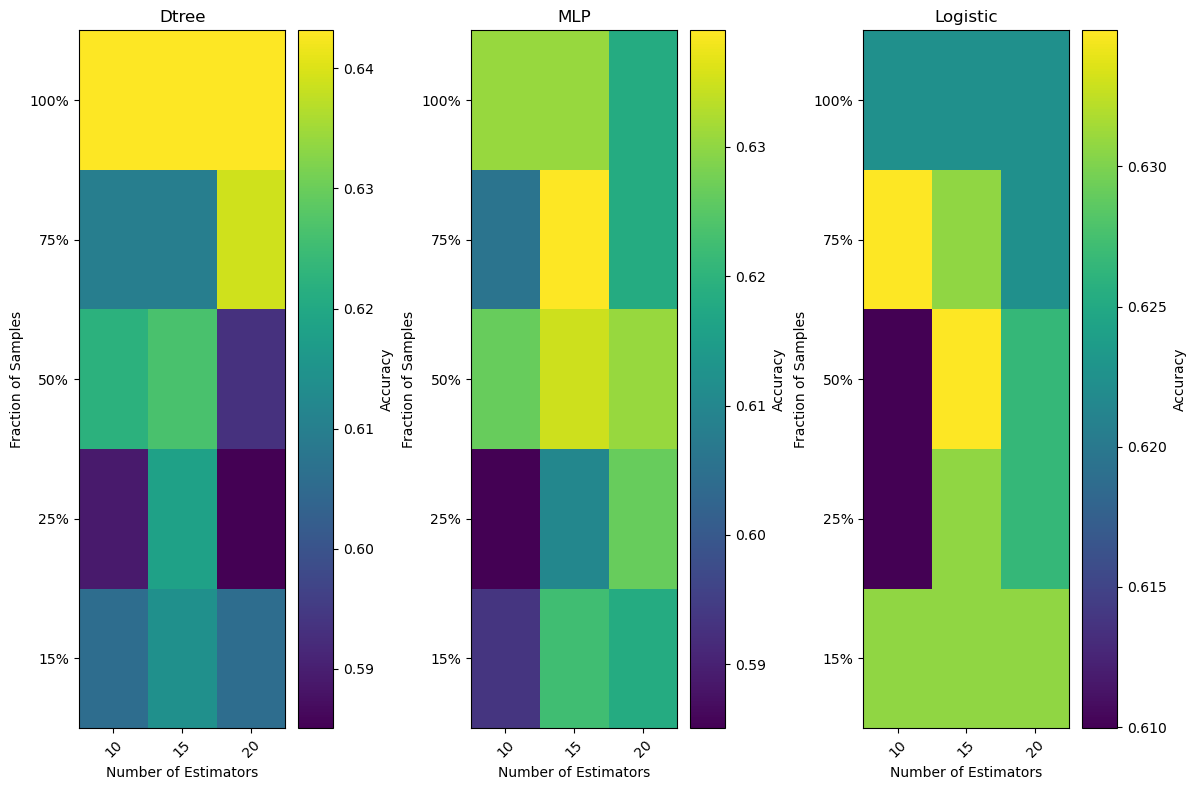

In [1330]:
frac_samples=[0.15,0.25,0.5,0.75,1]
num_estimators=[10,15,20]
mods=['Dtree','MLP','Logistic']
grid = np.zeros((len(mods), len(frac_samples), len(num_estimators)))
for i, base_estimator in enumerate(mods):
    for j, f in enumerate(frac_samples):
        for k, n_estimators in enumerate(num_estimators):
            bagger=BaggingClassifier(base_estimator,n_estimators,False,f,'soft')
            bagger.fit(x_wine_train,y_wine_train)
            out=bagger.predict(x_wine_test,x_wine_val,y_wine_val)
            grid[i, j, k] = accuracy_score(y_wine_test,out)
plt.figure(figsize=(12, 8))
for i, base_estimator in enumerate(mods):
    plt.subplot(1, len(mods), i + 1)
    plt.title(base_estimator)
    plt.imshow(grid[i], cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.xticks(np.arange(len(num_estimators)), num_estimators, rotation=45)
    plt.yticks(np.arange(len(frac_samples)), ['{:.0%}'.format(frac) for frac in frac_samples])
plt.tight_layout()
plt.show()

### Histogram for performance comparison for classification

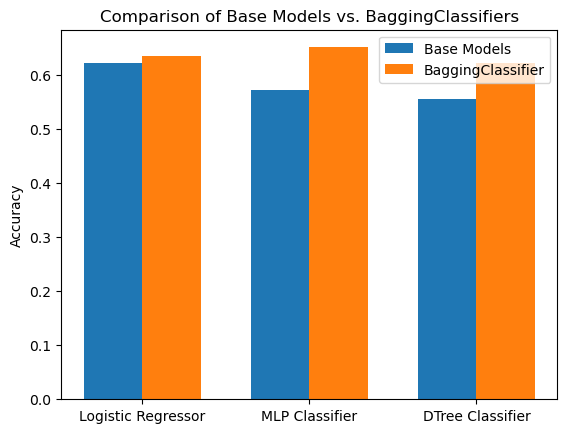

In [363]:
base_acc=[]
bagg_acc=[]
mods=['Logistic Regressor','MLP Classifier','DTree Classifier']
# Logistic
cf1=LogisticRegressor(0.001,10000)
cf1.fit(x_wine_train,y_wine_train)
base_acc.append(accuracy_score(y_wine_test,cf1.predict(x_wine_test)))
bcf1=BaggingClassifier('Logistic',10,True,0.5,'soft')
bcf1.fit(x_wine_train,y_wine_train)
out=bcf1.predict(x_wine_test,x_wine_val,y_wine_val)
bagg_acc.append(accuracy_score(y_wine_test,out))
# MLP
cf2=MLPClassifier(0.001,'ReLu','sgd',3,7)
cf2.fit(x_wine_train,y_wine_train,400)
l=cf2.predict(x_wine_test)
max_indices = np.argmax(l, axis=1).reshape(-1, 1)
new_matrix = np.zeros((max_indices.shape[0], 6), dtype=int)
rows, cols = np.arange(max_indices.shape[0]), max_indices.flatten()
new_matrix[rows, cols] = 1
base_acc.append(accuracy_score(y_wine_test,new_matrix))
bcf2=BaggingClassifier('MLP',20,False,1,'soft')
bcf2.fit(x_wine_train,y_wine_train)
out=bcf2.predict(x_wine_test,x_wine_val,y_wine_val)
bagg_acc.append(accuracy_score(y_wine_test,out))
# DTree
cf3=DecisionTreeClassifier(criterion='entropy',max_depth=9,max_features=7,random_state=67)
cf3.fit(x_wine_train,y_wine_train)
base_acc.append(accuracy_score(y_wine_test,cf3.predict(x_wine_test)))
bcf3=BaggingClassifier('Dtree',20,True,0.75,'soft')
bcf3.fit(x_wine_train,y_wine_train)
out=bcf3.predict(x_wine_test,x_wine_val,y_wine_val)
bagg_acc.append(accuracy_score(y_wine_test,out))
# Historgram for comparison
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,base_acc, width, label='Base Models')
bar2 = ax.bar(x + width/2, bagg_acc, width, label='BaggingClassifier')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Base Models vs. BaggingClassifiers')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()

### Bagging for Regression

In [1378]:
class BaggingRegressor:
    def __init__(self,model_type,num_models,bootstrap,samples,voting,rs):
        self.model=model_type
        self.num_estimators=num_models
        self.frac_samples=samples
        self.voting=voting
        self.bootstrap=bootstrap
        self.random_seed=rs
        mods=[]
        for _ in range(num_models):
            cf=None
            if model_type=='MLP':
                cf=MLPRegressor(0.0001,'sigmoid','mbgd',2,5)
            elif model_type=='Dtree':
                cf=DecisionTreeRegressor(max_depth=13,max_features=6,random_state=self.random_seed)
            else:
                cf=LinearRegressor(0.001,200000)
            mods.append(cf)
        self.estimators=mods
    def fit(self,x,y):
        np.random.seed(self.random_seed)
        for model in self.estimators:
            random_indices = np.random.choice(len(x), size=int(len(x)*self.frac_samples), replace=self.bootstrap)
            if self.model=='MLP':
                model.fit(x[random_indices],y[random_indices],20000)
            else:
                model.fit(x[random_indices],y[random_indices])
    def predict(self,x,x_val,y_val):
        val_r2score=[r2_score(y_val,model.predict(x_val)) for model in self.estimators]
        val_r2score=val_r2score/np.sum(val_r2score)
        predictions=[model.predict(x) for model in self.estimators]
        if self.voting=='soft':
            predictions=[a*val_r2score[i] for i,a in enumerate(predictions)]
        if self.model!='Dtree':
            predictions=[a.squeeze() for a in predictions]
        predictions_array = np.vstack(predictions)
        if self.voting=='soft':
            final_prediction = np.sum(predictions_array, axis=0)
        else:
            final_prediction = np.mean(predictions_array, axis=0)
        return final_prediction

In [1379]:
y_test_temp=y_test.squeeze()
rg=BaggingRegressor('Dtree',10,False,1,'soft',69)
rg.fit(x_train,y_train)
out=rg.predict(x_test,x_val,y_val)
print(r2_score(y_test_temp,out))

0.8660337347246756


### Running for all combinations of parameters

In [1332]:
scr=0
mod=None
y_test_temp=y_test.squeeze()
mods=['Dtree','MLP','Linear']
frac_samples=[0.15,0.25,0.5,0.75,1]
boots=[True,False]
vot=['hard','soft']
for m in mods:
    for f in frac_samples:
        for b in boots:
            for v in vot:
                rg=BaggingRegressor(m,10,b,f,v,69)
                rg.fit(x_train,y_train)
                out=rg.predict(x_test,x_val,y_val)
                score=r2_score(y_test_temp,out)
                if scr<score:
                    scr=score
                    mod=[m,f,b,v]
                print(f'Base Model: {m}, fraction of samples: {f}, Bootstrap: {b}, Voting: {v}, R2-Score: {r2_score(y_test_temp,out)}')
print(f"Best Model based on r2 score : Base model={mod[0]}, fraction of samples={mod[1]}, Bootstrap={mod[2]}, voting={mod[3]}")

Base Model: Dtree, fraction of samples: 0.15, Bootstrap: True, Voting: hard, R2-Score: 0.7294913960662197
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: True, Voting: soft, R2-Score: 0.6842392128985926
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: False, Voting: hard, R2-Score: 0.7053704177918317
Base Model: Dtree, fraction of samples: 0.15, Bootstrap: False, Voting: soft, R2-Score: 0.7632575853477492
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: True, Voting: hard, R2-Score: 0.7063833278544045
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: True, Voting: soft, R2-Score: 0.7380993858090645
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: False, Voting: hard, R2-Score: 0.7262134101185205
Base Model: Dtree, fraction of samples: 0.25, Bootstrap: False, Voting: soft, R2-Score: 0.7493418902358008
Base Model: Dtree, fraction of samples: 0.5, Bootstrap: True, Voting: hard, R2-Score: 0.7920874222358768
Base Model: Dtree, fraction of samples: 0.5

### Heatmaps for R2-Scores

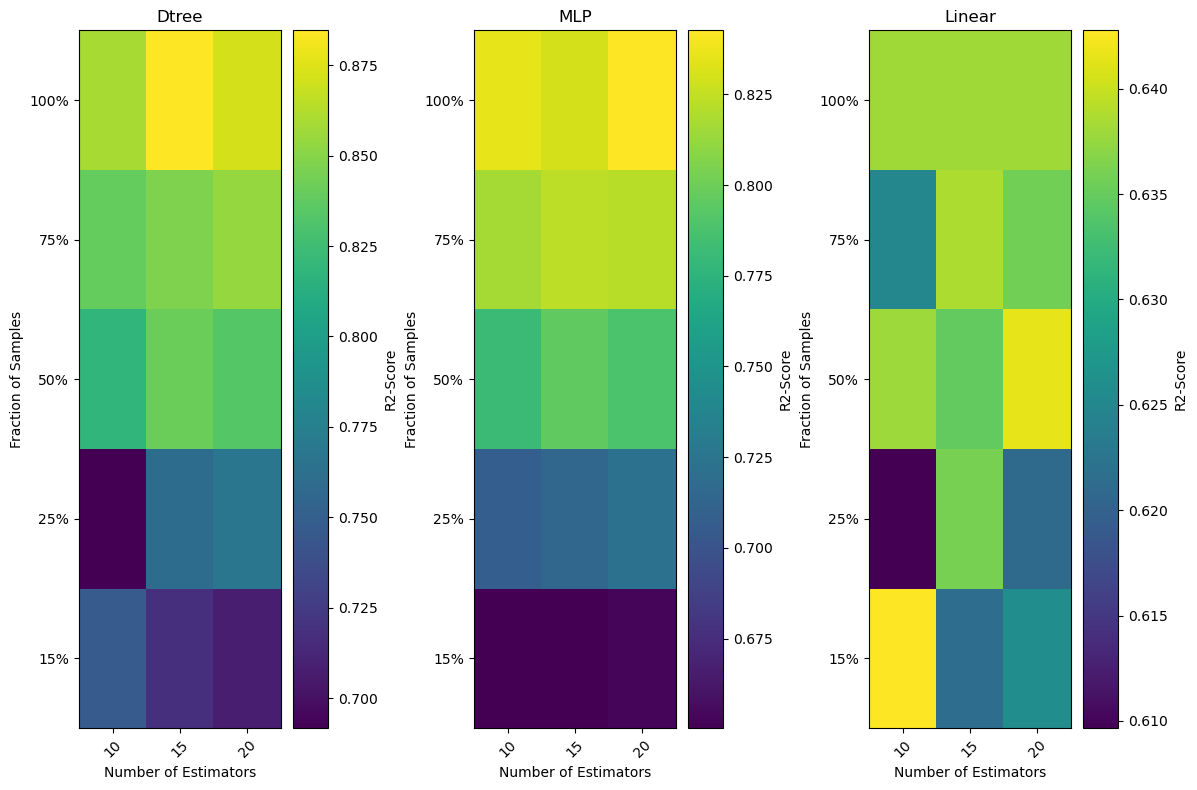

In [1333]:
frac_samples=[0.15,0.25,0.5,0.75,1]
num_estimators=[10,15,20]
mods=['Dtree','MLP','Linear']
grid = np.zeros((len(mods), len(frac_samples), len(num_estimators)))
for i, base_estimator in enumerate(mods):
    for j, f in enumerate(frac_samples):
        for k, n_estimators in enumerate(num_estimators):
            bagger=BaggingRegressor(base_estimator,n_estimators,False,f,'soft')
            bagger.fit(x_train,y_train)
            out=bagger.predict(x_test,x_val,y_val)
            grid[i, j, k] = r2_score(y_test_temp,out)
plt.figure(figsize=(12, 8))
for i, base_estimator in enumerate(mods):
    plt.subplot(1, len(mods), i + 1)
    plt.title(base_estimator)
    plt.imshow(grid[i], cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='R2-Score')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.xticks(np.arange(len(num_estimators)), num_estimators, rotation=45)
    plt.yticks(np.arange(len(frac_samples)), ['{:.0%}'.format(frac) for frac in frac_samples])
plt.tight_layout()
plt.show()

### Histogram for performance comparison for regression

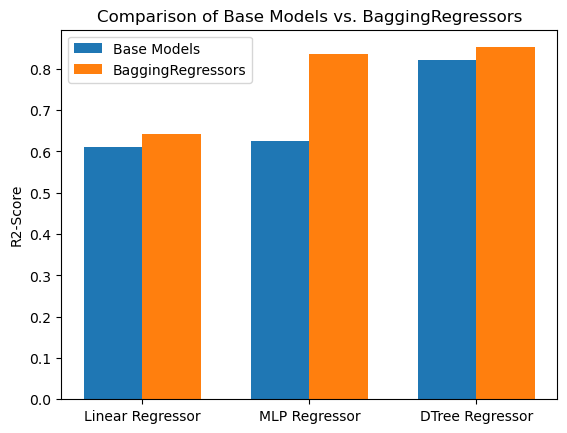

In [1351]:
base_acc=[]
bagg_acc=[]
mods=['Linear Regressor','MLP Regressor','DTree Regressor']
y_test_temp=y_test.squeeze()
# Linear
cf1=LinearRegressor(0.0001,50000)
cf1.fit(x_train,y_train)
base_acc.append(r2_score(y_test_temp,cf1.predict(x_test)))
bcf1=BaggingRegressor('Linear',10,True,0.75,'hard')
bcf1.fit(x_train,y_train)
out=bcf1.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
# MLP
cf2=MLPRegressor(0.0001,'tanh','mbgd',2,5)
cf2.fit(x_train,y_train,50000)
l=cf2.predict(x_test)
base_acc.append(r2_score(y_test_temp,l))
bcf2=BaggingRegressor('MLP',10,False,1,'hard')
bcf2.fit(x_train,y_train)
out=bcf2.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
# DTree
cf3=DecisionTreeRegressor(max_depth=15,max_features=6,random_state=10)
cf3.fit(x_train,y_train)
base_acc.append(r2_score(y_test_temp,cf3.predict(x_test)))
bcf3=BaggingRegressor('Dtree',10,False,1,'soft')
bcf3.fit(x_train,y_train)
out=bcf3.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
# Historgram for comparison
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,base_acc, width, label='Base Models')
bar2 = ax.bar(x + width/2, bagg_acc, width, label='BaggingRegressors')
ax.set_ylabel('R2-Score')
ax.set_title('Comparison of Base Models vs. BaggingRegressors')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()

## Stacking

### Stacking Classifier

In [1362]:
class StackingClassifier:
    def __init__(self,lev0_estims,lev1_estim,method):
        self.lev0names=lev0_estims
        self.lev1name=lev1_estim
        self.method=method
    def fit(self,x,y):
        mods=[]
        for est in self.lev0names:
            if est=='MLP':
                mods.append(MLPClassifier(0.001,'ReLu','sgd',3,7))
            elif est=='Dtree':
                mods.append(DecisionTreeClassifier(criterion='entropy',max_depth=9,max_features=7,random_state=67))
            else:
                mods.append(LogisticRegressor(0.001,10000))
        self.lev0=mods
        lev1=None
        if self.lev1name=='Dtree':
            lev1=DecisionTreeClassifier(criterion='entropy')
        else:
            lev1=LogisticRegressor(0.001,10000)
        self.lev1=lev1
        # Performing stacking or blending based on parameter
        if self.method=='stacking':
            predictions=[[] for _ in range(len(self.lev0names))]
            true_labs=[]
            k=5
            shuffled_indices = np.random.permutation(len(x))
            x_train_shuffled = x[shuffled_indices]
            y_train_shuffled = y[shuffled_indices]
            fold_size = len(x_train_shuffled) // k
            for i in range(k):
                x_test = x_train_shuffled[i*fold_size:(i+1)*fold_size]
                y_test = y_train_shuffled[i*fold_size:(i+1)*fold_size]
                x_train_remaining = np.concatenate((x_train_shuffled[:i*fold_size], x_train_shuffled[(i+1)*fold_size:]))
                y_train_remaining = np.concatenate((y_train_shuffled[:i*fold_size], y_train_shuffled[(i+1)*fold_size:]))
                true_labs.append(y_test)
                for j,mod in enumerate(self.lev0):
                    if self.lev0names[j]=='Dtree':
                        max_column_indices = np.argmax(y_train_remaining, axis=1)
                        y_temp=max_column_indices+3
                        mod.fit(x_train_remaining,y_temp)
                    elif self.lev0names[j]=='MLP':
                        mod.fit(x_train_remaining,y_train_remaining,400)
                    else:
                        mod.fit(x_train_remaining,y_train_remaining)
                    out=mod.predict(x_test)
                    if self.lev0names[j]!='Dtree':
                        max_column_indices = np.argmax(out, axis=1)
                        out=max_column_indices+3
                    predictions[j].append(out)
            for i,mod in enumerate(self.lev0):
                if self.lev0names[i]=='Dtree':
                    max_column_indices = np.argmax(y, axis=1)
                    y_temp=max_column_indices+3
                    mod.fit(x,y_temp)
                elif self.lev0names[i]=='MLP':
                    mod.fit(x,y,400)
                else:
                    mod.fit(x,y)
            predictions=[np.hstack(pr) for pr in predictions]
            true_labs=np.vstack(true_labs)
            x_train_meta=np.column_stack(predictions)
            y_train_meta=true_labs
            self.lev1.fit(x_train_meta,y_train_meta)
        else:
            x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=24)
            for i,mod in enumerate(self.lev0):
                if self.lev0names[i]=='Dtree':
                    max_column_indices = np.argmax(y_train, axis=1)
                    y_temp=max_column_indices+3
                    mod.fit(x_train,y_temp)
                elif self.lev0names[i]=='MLP':
                    mod.fit(x_train,y_train,400)
                else:
                    mod.fit(x_train,y_train)
            val_preds=[]
            for i,m in enumerate(self.lev0):
                pr=m.predict(x_val)
                if self.lev0names[i]!='Dtree':
                    max_column_indices = np.argmax(pr, axis=1)
                    pr=max_column_indices+3
                val_preds.append(pr)
            x_train_meta=np.column_stack(val_preds)
            y_train_meta=y_val
            self.lev1.fit(x_train_meta,y_train_meta)
    def predict(self,x):
        preds=[]
        for i,m in enumerate(self.lev0):
                pr=m.predict(x)
                if self.lev0names[i]!='Dtree':
                    max_column_indices = np.argmax(pr, axis=1)
                    pr=max_column_indices+3
                preds.append(pr)
        x_test_meta=np.column_stack(preds)
        out=self.lev1.predict(x_test_meta)
        if self.lev1name=='Dtree':
            temp=np.zeros((out.shape[0],6), dtype=int)
            temp[np.arange(pr.shape[0]), pr - 3] = 1
            out=temp
        return out

In [1363]:
new_xwine_train=np.concatenate((x_wine_train,x_wine_val), axis=0)
new_ywine_train=np.concatenate((y_wine_train,y_wine_val), axis=0)
stcf=StackingClassifier(['Dtree','MLP','Logistic'],'Dtree','blending')
stcf.fit(new_xwine_train,new_ywine_train)
out=stcf.predict(x_wine_test)
print(accuracy_score(y_wine_test,out))

0.6099585062240664


#### Tuning

In [1364]:
scr=0
mod=None
mod_dict=['Dtree','Linear']
for m1 in mod_dict:
    for typ in ['stacking','blending']:
        new_xwine_train=np.concatenate((x_wine_train,x_wine_val), axis=0)
        new_ywine_train=np.concatenate((y_wine_train,y_wine_val), axis=0)
        stcf=StackingClassifier(['Dtree','MLP','Logistic'],'Dtree','blending')
        stcf.fit(new_xwine_train,new_ywine_train)
        out=stcf.predict(x_wine_test)
        score=accuracy_score(y_wine_test,out)
        if score>scr:
            scr=score
            mod=[m1,typ,score]
print(mod)
print(f"Best performing stacking classifier model has parameters : Level-1 model={mod[0]}, type={mod[1]}")

['Dtree', 'stacking', 0.6099585062240664]
Best performing stacking classifier model has parameters : Level-1 model=Dtree, type=stacking


#### Comparing Accuracy and training time of best Bagging and Stacking ensembles for classification

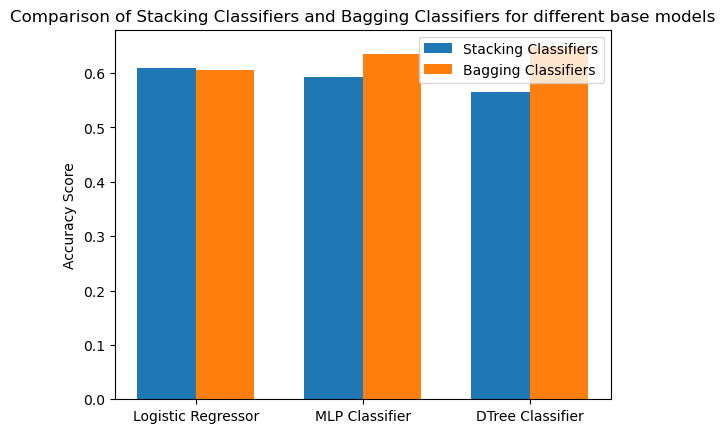

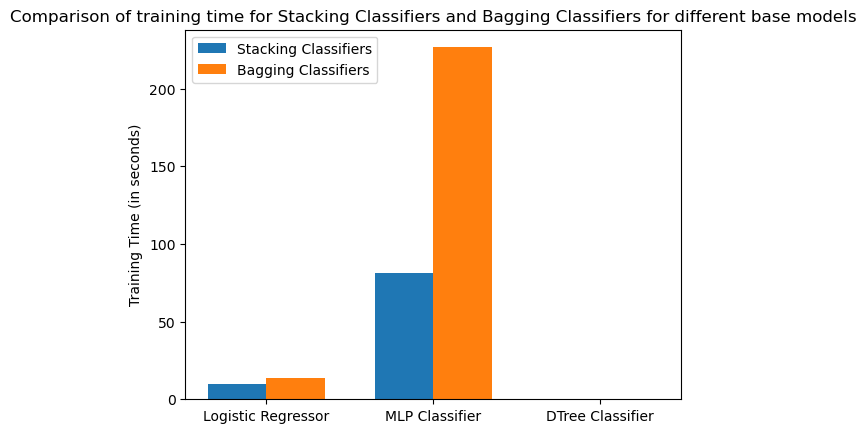

In [1390]:
stack_acc=[]
stack_time=[]
bag_time=[]
bagg_acc=[]
mods=['Logistic Regressor','MLP Classifier','DTree Classifier']
y_test_temp=y_test.squeeze()
# Logistic
bagger=BaggingClassifier('Logistic',10,False,0.25,'soft')
t1=time.time()
bagger.fit(x_wine_train,y_wine_train)
t2=time.time()
bag_time.append(t2-t1)
out=bagger.predict(x_wine_test,x_wine_val,y_wine_val)
score=accuracy_score(y_wine_test,out)
bagg_acc.append(score)
new_xwine_train=np.concatenate((x_wine_train,x_wine_val), axis=0)
new_ywine_train=np.concatenate((y_wine_train,y_wine_val), axis=0)
stcf=StackingClassifier(['Logistic','Logistic','Logistic'],'Dtree','blending')
t1=time.time()
stcf.fit(new_xwine_train,new_ywine_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_wine_test)
stack_acc.append(accuracy_score(y_wine_test,out))
# MLP
bagger=BaggingClassifier('MLP',10,True,0.75,'hard')
t1=time.time()
bagger.fit(x_wine_train,y_wine_train)
t2=time.time()
bag_time.append(t2-t1)
out=bagger.predict(x_wine_test,x_wine_val,y_wine_val)
score=accuracy_score(y_wine_test,out)
bagg_acc.append(score)
stcf=StackingClassifier(['MLP','MLP','MLP'],'Dtree','blending')
t1=time.time()
stcf.fit(new_xwine_train,new_ywine_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_wine_test)
stack_acc.append(accuracy_score(y_wine_test,out))
# DTree
bagger=BaggingClassifier('Dtree',10,True,0.75,'soft')
t1=time.time()
bagger.fit(x_wine_train,y_wine_train)
t2=time.time()
bag_time.append(t2-t1)
out=bagger.predict(x_wine_test,x_wine_val,y_wine_val)
score=accuracy_score(y_wine_test,out)
bagg_acc.append(score)
stcf=StackingClassifier(['Dtree','Dtree','Dtree'],'Dtree','blending')
t1=time.time()
stcf.fit(new_xwine_train,new_ywine_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_wine_test)
stack_acc.append(accuracy_score(y_wine_test,out))
# Historgram for comparison
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,stack_acc, width, label='Stacking Classifiers')
bar2 = ax.bar(x + width/2,bagg_acc, width, label='Bagging Classifiers')
ax.set_ylabel('Accuracy Score')
ax.set_title('Comparison of Stacking Classifiers and Bagging Classifiers for different base models')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,stack_time, width, label='Stacking Classifiers')
bar2 = ax.bar(x + width/2,bag_time, width, label='Bagging Classifiers')
ax.set_ylabel('Training Time (in seconds)')
ax.set_title('Comparison of training time for Stacking Classifiers and Bagging Classifiers for different base models')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()

### Stacking Regressor

In [1386]:
class StackingRegressor:
    def __init__(self,lev0_estims,lev1_estim,method,rs):
        self.lev0names=lev0_estims
        self.lev1name=lev1_estim
        self.method=method
        self.random_state=rs
    def fit(self,x,y):
        mods=[]
        for est in self.lev0names:
            if est=='MLP':
                mods.append(MLPRegressor(0.0001,'sigmoid','mbgd',2,5))
            elif est=='Dtree':
                mods.append(DecisionTreeRegressor(max_depth=12,max_features=4,random_state=10))
            else:
                mods.append(LinearRegressor(0.001,200000))
        self.lev0=mods
        lev1=None
        if self.lev1name=='Dtree':
            lev1=DecisionTreeRegressor(random_state=self.random_state)
        else:
            lev1=LinearRegressor(0.001,200000)
        self.lev1=lev1
        # Performing stacking or blending based on parameter
        if self.method=='stacking':
            predictions=[[] for _ in range(len(self.lev0names))]
            true_labs=[]
            k=5
            np.random.seed(self.random_state)
            shuffled_indices = np.random.permutation(len(x))
            x_train_shuffled = x[shuffled_indices]
            y_train_shuffled = y[shuffled_indices]
            fold_size = len(x_train_shuffled) // k
            for i in range(k):
                x_test = x_train_shuffled[i*fold_size:(i+1)*fold_size]
                y_test = y_train_shuffled[i*fold_size:(i+1)*fold_size]
                x_train_remaining = np.concatenate((x_train_shuffled[:i*fold_size], x_train_shuffled[(i+1)*fold_size:]))
                y_train_remaining = np.concatenate((y_train_shuffled[:i*fold_size], y_train_shuffled[(i+1)*fold_size:]))
                true_labs.append(y_test)
                for j,mod in enumerate(self.lev0):
                    if self.lev0names[j]=='MLP':
                        mod.fit(x_train_remaining,y_train_remaining,20000)
                    else:
                        mod.fit(x_train_remaining,y_train_remaining)
                    out=mod.predict(x_test)
                    if self.lev0names[j]!='Dtree':
                        out=out.squeeze()
                    predictions[j].append(out)
            for i,mod in enumerate(self.lev0):
                if self.lev0names[i]=='MLP':
                    mod.fit(x,y,20000)
                else:
                    mod.fit(x,y)
            predictions=[np.hstack(pr) for pr in predictions]
            # scalars=[]
            # scaled_preds=[]
            # for p in predictions:
            #     sc=StandardScaler()
            #     p=p.reshape(-1,1)
            #     scaled_preds.append((sc.fit_transform(p)).squeeze())
            #     scalars.append(sc)
            # self.scalars=scalars
            # predictions=scaled_preds
            true_labs=np.vstack(true_labs)
            x_train_meta=np.column_stack(predictions)
            y_train_meta=true_labs
            self.lev1.fit(x_train_meta,y_train_meta)
        else:
            x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=24)
            for i,mod in enumerate(self.lev0):
                if self.lev0names[i]=='MLP':
                    mod.fit(x_train,y_train,20000)
                else:
                    mod.fit(x_train,y_train)
            val_preds=[]
            for i,m in enumerate(self.lev0):
                pr=m.predict(x_val)
                if self.lev0names[i]!='Dtree':
                    pr=pr.squeeze()
                val_preds.append(pr)
            x_train_meta=np.column_stack(val_preds)
            y_train_meta=y_val
            self.lev1.fit(x_train_meta,y_train_meta)
    def predict(self,x):
        preds=[]
        for i,m in enumerate(self.lev0):
                pr=m.predict(x)
                if self.lev0names[i]!='Dtree':
                    pr=pr.squeeze()
                preds.append(pr)
        # if self.method=='stacking':
        #     temp=[]
        #     for i,sc in enumerate(self.scalars):
        #         to_scale=preds[i].reshape(-1,1)
        #         temp.append((sc.transform(to_scale)).squeeze())
        #     preds=temp
        x_test_meta=np.column_stack(preds)
        out=self.lev1.predict(x_test_meta)
        return out

In [1387]:
y_test_temp=y_test.squeeze()
new_xhousing_train=np.concatenate((x_train,x_val), axis=0)
new_yhousing_train=np.concatenate((y_train,y_val), axis=0)
stcf=StackingRegressor(['Dtree','Dtree','Dtree'],'Linear','blending',10)
stcf.fit(new_xhousing_train,new_yhousing_train)
out=stcf.predict(x_test)
print(r2_score(y_test_temp,out))

0.8126724314575446


#### Tuning

In [1355]:
scr=0
mod=None
mod_dict=['Dtree','Linear']
for m1 in mod_dict:
    for typ in ['stacking','blending']:
        y_test_temp=y_test.squeeze()
        new_xhousing_train=np.concatenate((x_train,x_val), axis=0)
        new_yhousing_train=np.concatenate((y_train,y_val), axis=0)
        stcf=StackingRegressor(['Dtree','MLP','Linear'],m1,typ,10)
        stcf.fit(new_xhousing_train,new_yhousing_train)
        out=stcf.predict(x_test)
        score=r2_score(y_test_temp,out)
        if score>scr:
            scr=score
            mod=[m1,typ,score]
print(mod)
print(f"Best performing stacking regressor model has parameters : Level-1 model={mod[0]}, type={mod[1]}")

['Linear', 'stacking', 0.8241372818654662]
Best performing stacking regressor model has parameters : Level-1 model=Linear, type=stacking


#### Comparing Accuracy and training time of best Bagging and Stacking ensembles for regression

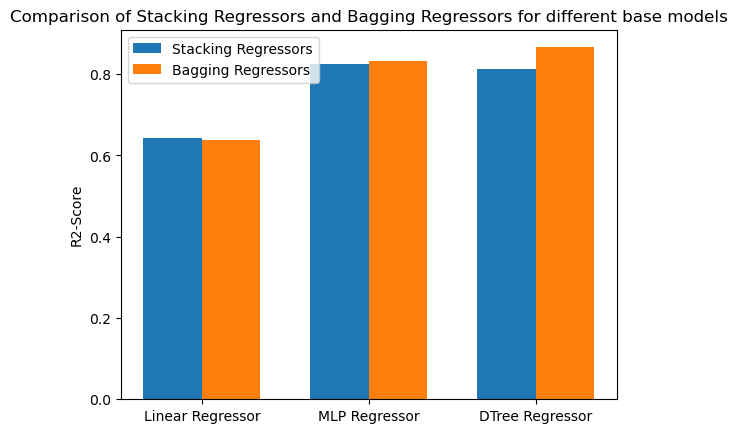

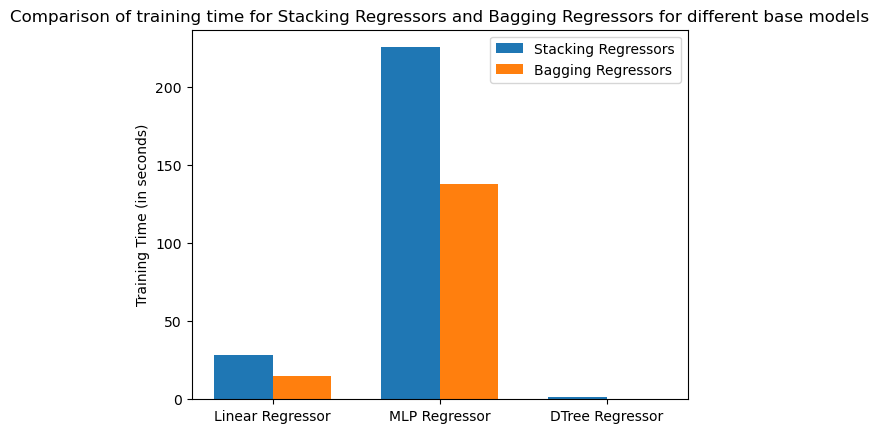

In [1389]:
stack_acc=[]
stack_time=[]
bag_time=[]
bagg_acc=[]
mods=['Linear Regressor','MLP Regressor','DTree Regressor']
y_test_temp=y_test.squeeze()
# Linear
rg=BaggingRegressor('Linear',10,False,1,'soft',69)
t1=time.time()
rg.fit(x_train,y_train)
t2=time.time()
bag_time.append(t2-t1)
out=rg.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
new_xhousing_train=np.concatenate((x_train,x_val), axis=0)
new_yhousing_train=np.concatenate((y_train,y_val), axis=0)
stcf=StackingRegressor(['Linear','Linear','Linear'],'Linear','stacking',10)
t1=time.time()
stcf.fit(new_xhousing_train,new_yhousing_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_test)
stack_acc.append(r2_score(y_test_temp,out))
# MLP
rg=BaggingRegressor('MLP',10,False,1,'soft',69)
t1=time.time()
rg.fit(x_train,y_train)
t2=time.time()
bag_time.append(t2-t1)
out=rg.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
stcf=StackingRegressor(['MLP','MLP','MLP'],'Linear','stacking',10)
t1=time.time()
stcf.fit(new_xhousing_train,new_yhousing_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_test)
stack_acc.append(r2_score(y_test_temp,out))
# DTree
rg=BaggingRegressor('Dtree',10,False,1,'soft',69)
t1=time.time()
rg.fit(x_train,y_train)
t2=time.time()
bag_time.append(t2-t1)
out=rg.predict(x_test,x_val,y_val)
bagg_acc.append(r2_score(y_test_temp,out))
stcf=StackingRegressor(['Dtree','Dtree','Dtree'],'Linear','blending',10)
t1=time.time()
stcf.fit(new_xhousing_train,new_yhousing_train)
t2=time.time()
stack_time.append(t2-t1)
out=stcf.predict(x_test)
stack_acc.append(r2_score(y_test_temp,out))
# Historgram for comparison
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,stack_acc, width, label='Stacking Regressors')
bar2 = ax.bar(x + width/2,bagg_acc, width, label='Bagging Regressors')
ax.set_ylabel('R2-Score')
ax.set_title('Comparison of Stacking Regressors and Bagging Regressors for different base models')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3)
bar1 = ax.bar(x - width/2,stack_time, width, label='Stacking Regressors')
bar2 = ax.bar(x + width/2,bag_time, width, label='Bagging Regressors')
ax.set_ylabel('Training Time (in seconds)')
ax.set_title('Comparison of training time for Stacking Regressors and Bagging Regressors for different base models')
ax.set_xticks(x)
ax.set_xticklabels(mods)
ax.legend()
plt.show()

## Section-4

### Random Forest Classifier

In [1434]:
wine_data=pd.read_csv('WineQT.csv')
X_wine=wine_data.loc[:,~wine_data.columns.isin(['quality','Id'])]
y_wine=wine_data['quality'].values
temp=np.zeros((y_wine.shape[0],6), dtype=int)
temp[np.arange(y_wine.shape[0]), y_wine - 3] = 1
new_array = np.zeros((temp.shape[0], 2), dtype=int)
new_array[:, 0] = np.any(temp[:, :3], axis=1)
new_array[:, 1] = np.any(temp[:, 3:], axis=1)
y_wine=new_array
x_wine_train, x_temp, y_wine_train, y_temp = train_test_split(X_wine, y_wine, test_size=0.4, random_state=42)
x_wine_val, x_wine_test, y_wine_val, y_wine_test = train_test_split(x_temp, y_temp, test_size=0.75, random_state=42)
scalar=StandardScaler()
scalar.fit(x_wine_train)
x_wine_train=scalar.transform(x_wine_train)
x_wine_val=scalar.transform(x_wine_val)
x_winetest_original=x_wine_test
x_wine_test=scalar.transform(x_wine_test)

In [1139]:
class RandomForestClassifier:
    def __init__(self,n_estims,max_features,max_depth,frac_samples,bootstrap,voting,random_state):
        self.n_estimators=n_estims
        self.frac=frac_samples
        self.bootstrap=bootstrap
        self.max_features=max_features
        self.max_depth=max_depth
        self.random_state=random_state
        self.models = []
        self.voting=voting
    def fit(self,X,y):
        max_column_indices = np.argmax(y, axis=1)
        y=max_column_indices
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            indices = np.random.choice(X.shape[0], size=int(self.frac*X.shape[0]), replace=self.bootstrap)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            # Feature Sampling
            if self.max_features is not None:
                selected_features = np.random.choice(X.shape[1], size=self.max_features, replace=False)
                X_bootstrap = X_bootstrap[:, selected_features]
            tree = DecisionTreeClassifier(criterion='entropy',max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append((tree, selected_features))
    def predict(self,X):
        if self.voting=='soft':
            prob_predictions = [tree.predict_proba(X[:, features]) for tree,features in self.models]
            concatenated_array = np.array(prob_predictions)
            sum_array = np.sum(concatenated_array, axis=0)
            higher_second_column = sum_array[:, 1] > sum_array[:, 0]
            temp= higher_second_column.astype(int)
            return np.eye(2)[temp]
        predictions = [tree.predict(X[:, features]) for tree,features in self.models]
        new_pred=[]
        for pr in predictions:
            temp=np.zeros((pr.shape[0],2), dtype=int)
            temp[np.arange(pr.shape[0]),pr] = 1
            new_pred.append(temp)
        predictions=new_pred
        m,n =predictions[0].shape
        final_matrix=np.zeros((m, n))
        for i in range(m):
            column_sums=[0] * n
            for arr in predictions:
                column_sums+=arr[i]
            max_column=np.argmax(column_sums)
            one_hot_row=np.zeros(n)
            one_hot_row[max_column]=1
            final_matrix[i] = one_hot_row
        return final_matrix

In [1147]:
x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
rf=RandomForestClassifier(200,6,20,1,True,'hard',20)
rf.fit(x_train_temp,y_train_temp)
print(accuracy_score(y_wine_test,rf.predict(x_wine_test)))

0.7965116279069767


### Tuning hyper-parameters

In [1144]:
max_fet=range(1,12)
num_ests=[100,200,300,400]
scr=0
max_depth=[5,10,15,20]
ran=[10,13,15,20,25]
mod=None
x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
for mf in max_fet:
    for dep in max_depth:
        for rs in ran:
            for ns in num_ests:
                rf=RandomForestClassifier(ns,mf,dep,1,True,'hard',rs)
                rf.fit(x_train_temp,y_train_temp)
                score=accuracy_score(y_wine_test,rf.predict(x_wine_test))
                if score>scr:
                    scr=score
                    mod=[mf,dep,rs,ns,score]
print(mod)

[6, 20, 20, 200, 0.7965116279069767]


In [645]:
mod=None
scr=0
vo=['hard','soft']
boot=[False,True]
fra=[0.15,0.25,0.5,0.75,1]
for v in vo:
    for b in boot:
        for f in fra:
            rf=RandomForestClassifier(100,7,20,f,b,v,20)
            rf.fit(x_wine_train,y_wine_train)
            score=accuracy_score(y_wine_test,rf.predict(x_wine_test,x_wine_val,y_wine_val))
            if score>scr:
                scr=score
                mod=[v,b,f,score]
print(mod)

['hard', True, 1, 0.7558139534883721]


#### So, The best performing hyper-parameters for Random Forest Classifier are : Estimators - 100 ,Voting - 'hard', Fraction of samples - 1, Bootstrap - True, max_features=7, max_depth=20

### Random Forest Regressor

In [1397]:
data=pd.read_csv('HousingData.csv')
mean_cols=['CRIM','ZN','INDUS','AGE','LSTAT']
for col in mean_cols:
    mean_imputer = SimpleImputer(strategy='mean')
    data[col]=mean_imputer.fit_transform(data[[col]])
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
data['CHAS']=most_frequent_imputer.fit_transform(data[['CHAS']])
x=data.loc[:,~data.columns.isin(['MEDV'])].values
y=data['MEDV'].values
y=y.reshape(-1,1)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.75, random_state=42)
scalar=StandardScaler()
scalar.fit(x_train)
x_train=scalar.transform(x_train)
x_val=scalar.transform(x_val)
x_test=scalar.transform(x_test)

In [1207]:
class RandomForestRegressor:
    def __init__(self,n_estims,max_features,max_depth,frac_samples,bootstrap,voting,random_state):
        self.n_estimators=n_estims
        self.frac=frac_samples
        self.bootstrap=bootstrap
        self.max_features=max_features
        self.max_depth=max_depth
        self.random_state=random_state
        self.models = []
        self.voting=voting
    def fit(self,X,y):
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            indices = np.random.choice(X.shape[0], size=int(self.frac*X.shape[0]), replace=self.bootstrap)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            # Feature Sampling
            if self.max_features is not None:
                selected_features = np.random.choice(X.shape[1], size=self.max_features, replace=False)
                X_bootstrap = X_bootstrap[:, selected_features]
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append((tree, selected_features))
    def predict(self,X,x_val,y_val):
        val_r2score=[r2_score(y_val,model.predict(x_val[:,feat])) for model,feat in self.models]
        val_r2score=val_r2score/np.sum(val_r2score)
        predictions=[model.predict(X[:,feat]) for model,feat in self.models]
        if self.voting=='soft':
            predictions=[a*val_r2score[i] for i,a in enumerate(predictions)]
        predictions_array = np.vstack(predictions)
        if self.voting=='soft':
            final_prediction = np.sum(predictions_array, axis=0)
        else:
            final_prediction = np.mean(predictions_array, axis=0)
        return final_prediction

In [1208]:
x_train_temp=np.concatenate((x_train,x_val), axis=0)
y_train_temp=np.concatenate((y_train,y_val), axis=0)
rfr=RandomForestRegressor(50,10,20,1,True,'hard',42)
rfr.fit(x_train_temp,y_train_temp)
out=rfr.predict(x_test,x_val,y_val)
print(r2_score(y_test,out))

0.877247582838009


### Tuning hyper-parameters

In [670]:
max_fet=range(1,12)
num_ests=[100,200,300,400]
scr=0
max_depth=[5,10,15,20]
ran=[10,13,15,20,25]
mod=None
for mf in max_fet:
    for dep in max_depth:
        for rs in ran:
            for ns in num_ests:
                rfr=RandomForestRegressor(ns,mf,dep,1,True,'hard',rs)
                rfr.fit(x_train,y_train)
                score=r2_score(y_test,rfr.predict(x_test,x_val,y_val))
                if score>scr:
                    scr=score
                    mod=[mf,dep,rs,ns,score]
print(mod)

[10, 20, 20, 100, 0.855715159729521]


In [676]:
mod=None
scr=0
vo=['hard','soft']
boot=[False,True]
fra=[0.15,0.25,0.5,0.75,1]
for v in vo:
    for b in boot:
        for f in fra:
            rfr=RandomForestRegressor(100,10,20,f,b,v,20)
            rfr.fit(x_train,y_train)
            score=r2_score(y_test,rfr.predict(x_test,x_val,y_val))
            if score>scr:
                scr=score
                mod=[v,b,f,score]
print(mod)

['hard', True, 1, 0.855715159729521]


#### So, The best performing hyper-parameters for Random Forest Regressor are : Estimators - 100 ,Voting - 'hard', Fraction of samples - 1, Bootstrap - True, max_features=10, max_depth=20

### Gradient Boosted Classifier

In [1161]:
class GradientBoostedClassifier:
    def __init__(self,n_estimators,lrate,max_depth,max_features,leaves,rdstate):
        self.n_estimators=n_estimators
        self.lrate=lrate
        self.max_depth=max_depth
        self.max_features=max_features
        self.models=[]
        self.max_leaves=leaves
        self.random_state=rdstate
    def fit(self, X, y):
        self.initial=np.log(np.sum(y==1)/np.sum(y==0))
        for _ in range(self.n_estimators):
            curr_preds=self.predict(X)
            residuals=y-curr_preds
            tree=DecisionTreeRegressor(max_depth=self.max_depth,max_features=self.max_features, max_leaf_nodes=self.max_leaves,random_state=self.random_state)
            tree.fit(X,residuals)
            leaf_nodes = tree.apply(X)
            for leaf_index in np.unique(leaf_nodes):
                indices=np.where(leaf_nodes == leaf_index)[0]
                new_leaf_value = np.sum(residuals[indices])/np.sum(curr_preds[indices]*(1-curr_preds[indices]))
                tree.tree_.value[leaf_index] = [[new_leaf_value]]
            self.models.append(tree)
    def predict(self, X):
        pred=[]
        s=np.zeros(X.shape[0])
        for mod in self.models:
            pred.append(mod.predict(X)*self.lrate)
        s+=np.sum(pred,axis=0)
        return np.exp(s+self.initial)/(1+np.exp(s+self.initial))

In [1196]:
x_wtrain_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_wtrain_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
y_winetest_temp=np.where(y_wine_test[:, 0] == 1, 0, 1)
y_winetrain_temp=np.where(y_wtrain_temp[:, 0] == 1, 0, 1)
gbc=GradientBoostedClassifier(100,0.1,6,7,8,15)
gbc.fit(x_wtrain_temp,y_winetrain_temp)
out=gbc.predict(x_wine_test)
out=(out>=0.5).astype(int)
print(accuracy_score(y_winetest_temp,out))

0.7732558139534884


#### Tuning

In [1197]:
scr=0
mod=None
for est in [200]:
    for md in range(1,15):
            for mf in range(1,11):
                clf = GradientBoostedClassifier(est,0.1,md,mf,8,15)
                clf.fit(x_wtrain_temp,y_winetrain_temp)
                y_pred = clf.predict(x_wine_test)
                y_pred=(y_pred>=0.5).astype(int)
                score=accuracy_score(y_winetest_temp,y_pred)
                if score>scr:
                    scr=score
                    mod=[est,md,mf,score]
print(mod)

[200, 5, 8, 0.7732558139534884]


#### So, the best Accuracy score is obtained for model with following hyper-parameters: Learning Rate - 0.01, Max_Depth - 4 and Number of Estimators - 300

### Gradient Boosted Regressor

In [1000]:
class GradientBoostedRegressor:
    def __init__(self,n_estimators,lrate,max_depth,max_features,leaves,rs):
        self.n_estimators=n_estimators
        self.lrate=lrate
        self.max_depth=max_depth
        self.max_features=max_features
        self.models=[]
        self.random_state=rs
        self.max_leaves=leaves
    def fit(self, X, y):
        self.initial=np.mean(y)
        for _ in range(self.n_estimators):
            residuals=y-self.predict(X)
            tree=DecisionTreeRegressor(max_depth=self.max_depth,max_features=self.max_features, max_leaf_nodes=self.max_leaves,random_state=self.random_state)
            tree.fit(X,residuals)
            self.models.append(tree)
    def predict(self, X):
        pred=[]
        s=np.zeros(X.shape[0])
        for mod in self.models:
            pred.append(mod.predict(X)*self.lrate)
        s+=np.sum(pred,axis=0)
        return s+self.initial

In [1010]:
x_train_temp=np.concatenate((x_train,x_val), axis=0)
y_train_temp=np.concatenate((y_train,y_val), axis=0)
y_train_temp=y_train_temp.squeeze()
gbr=GradientBoostedRegressor(300,0.1,5,10,6,117)
gbr.fit(x_train_temp,y_train_temp)
out=gbr.predict(x_test)
print(r2_score(y_test.squeeze(),out))

0.9098892785998971


#### Tuning

In [1009]:
scr=0
mod=None
for est in [100,200,300,400,500]:
    for md in [5,10,15,20,25]:
        for lr in [0.1,0.01]:
            clf = GradientBoostedRegressor(est,lr,md,10,6,117)
            clf.fit(x_train_temp,y_train_temp)
            y_pred = clf.predict(x_test)
            score=r2_score(y_test.squeeze(),y_pred)
            if score>scr:
                scr=score
                mod=[est,md,lr,score]
print(mod)

[300, 5, 0.1, 0.9098892785998971]


#### So, the best R2-Score is obtained for model with following hyper-parameters: Learning Rate - 0.1, Max_Depth - 5 and Number of Estimators - 300

### AdaBoost Classifier

In [1150]:
class AdaBoostClassifier:
    def __init__(self, n_estimators,rs):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []
        self.rs=rs
    def fit(self, X, y):
        n_samples,_= X.shape
        weights = np.ones(n_samples) / n_samples
        self.models = []
        np.random.seed(self.rs)
        for _ in range(self.n_estimators):
            indices=np.random.choice(n_samples,size=n_samples,p=weights,replace=True)
            model = DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=self.rs)
            model.fit(X[indices],y[indices])
            predictions = model.predict(X)
            weighted_error = np.sum(weights * (predictions != y))
            alpha = 0.5 * np.log((1 - weighted_error) / max(weighted_error, 1e-10))
            self.alphas.append(alpha)
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)
            self.models.append(model)
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return (np.sign(np.dot(self.alphas, predictions))).astype(int)

In [1156]:
x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
y_test_temp=np.where(y_wine_test[:, 0] == 1, -1, 1)
y_train_temp=np.where(y_train_temp[:, 0] == 1, -1, 1)
abc=AdaBoostClassifier(140,67)
abc.fit(x_train_temp,y_train_temp)
out=abc.predict(x_wine_test)
print(accuracy_score(y_test_temp,out))

0.7906976744186046


### Tuning

In [1155]:
scr=0
mod=None
for est in range(10,200,10):
        for rs in range(1,100):
                cf=AdaBoostClassifier(est,rs)
                cf.fit(x_train_temp,y_train_temp)
                out=cf.predict(x_wine_test)
                score=accuracy_score(y_test_temp,out)
                if score>scr:
                        scr=score
                        mod=[est,rs,score]
print(mod)

[140, 67, 0.7906976744186046]


#### So, the best Accuracy Score is obtained for model with Number of Estimators = 140

### Adaboost Regressor

In [1060]:
class AdaBoostRegressor:
    def __init__(self,n_estimators,max_depth):
        self.n_estimators = n_estimators
        self.models = []
        self.betas = []
        self.max_depth=max_depth
        self.model_weights=[]
    def fit(self, X, y):
        n_samples,_= X.shape
        sample_weights = np.ones(n_samples) / n_samples
        np.random.seed(46)
        for _ in range(self.n_estimators):
            indices=np.random.choice(n_samples,size=n_samples,p=sample_weights,replace=True)
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X[indices],y[indices])
            predictions = model.predict(X)
            abs_errors=np.abs(y-predictions)
            max_abs_error=np.max(abs_errors)
            Lts=abs_errors/max_abs_error
            Lmean=np.sum(sample_weights*Lts)
            if Lmean>=0.5:
                break
            beta=Lmean/(1-Lmean)
            self.betas.append(beta)
            tot_zt=np.sum(sample_weights*(beta**(1-Lts)))
            sample_weights*=beta**(1-Lts)/tot_zt
            self.models.append(model)
        self.model_weights = np.log(1/np.array(self.betas))
    def weighted_median(self,values, weights):
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
        return values[median_weight]
    def predict(self, X):
        N_test = X.shape[0]
        fitted_values = np.empty((N_test, len(self.models)))
        for t, tree in enumerate(self.models):
            fitted_values[:,t] = tree.predict(X)
        return np.array([self.weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)]) 

In [1064]:
x_train_temp=np.concatenate((x_train,x_val), axis=0)
y_train_temp=np.concatenate((y_train,y_val), axis=0)
abr=AdaBoostRegressor(30,14)
abr.fit(x_train_temp,y_train_temp.squeeze())
out=abr.predict(x_test)
print(r2_score(y_test,out))

0.8986950176708208


#### Tuning

In [1063]:
scr=0
mod=None
for est in [10,20,30,40,50,100,130,150,200,300,400]:
        for md in range(1,25):
                abr=AdaBoostRegressor(est,md)
                abr.fit(x_train_temp,y_train_temp.squeeze())
                out=abr.predict(x_test)
                score=r2_score(y_test,out)
                if score>scr:
                        scr=score
                        mod=[est,md,score]
print(mod)

[30, 14, 0.8986950176708208]


#### So, the best R2-Score is obtained for model with following hyper-parameters: Max_Depth - 14 and Number of Estimators - 30

### Comparison Between Random Forest Classifier with AdaBoost Classifier

#### We see that the best performing model for AdaBoost Classifier has slightly higher accuracy than Random Forest Classifier.

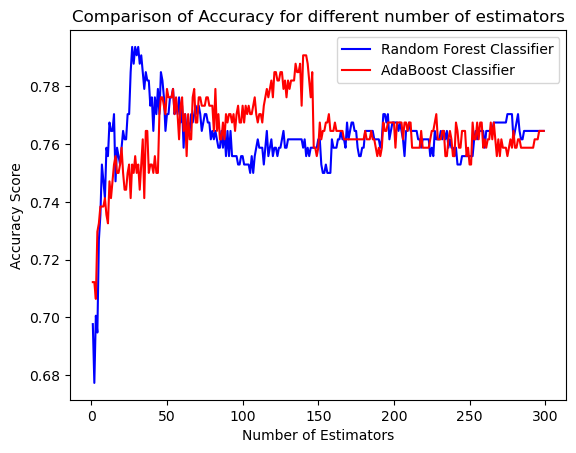

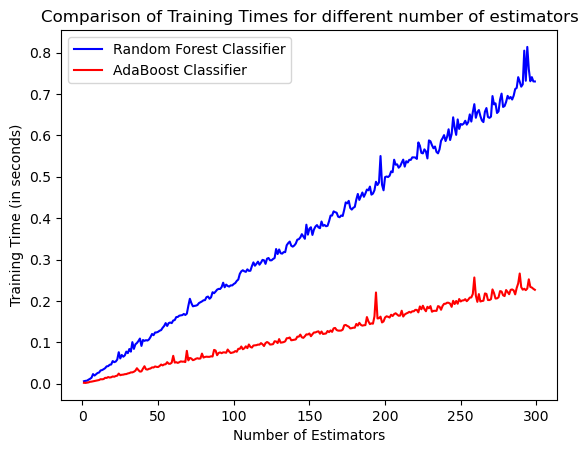

In [1213]:
rfacc_arr=[]
abacc_arr=[]
rf_time=[]
abc_time=[]
num_est=range(1,300)
for est in num_est:
    x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
    y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
    rf=RandomForestClassifier(est,7,20,1,True,'hard',30)
    t1=time.time()
    rf.fit(x_train_temp,y_train_temp)
    t2=time.time()
    rf_time.append(t2-t1)
    rfacc_arr.append(accuracy_score(y_wine_test,rf.predict(x_wine_test)))
    y_test_temp=np.where(y_wine_test[:, 0] == 1, -1, 1)
    y_train_temp=np.where(y_train_temp[:, 0] == 1, -1, 1)
    abc=AdaBoostClassifier(est,67)
    t1=time.time()
    abc.fit(x_train_temp,y_train_temp)
    t2=time.time()
    abc_time.append(t2-t1)
    out=abc.predict(x_wine_test)
    abacc_arr.append(accuracy_score(y_test_temp,out))
plt.plot(num_est,rfacc_arr,label='Random Forest Classifier',color='blue')
plt.plot(num_est,abacc_arr,label='AdaBoost Classifier',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy for different number of estimators')
plt.legend()
plt.show()
plt.plot(num_est,rf_time,label='Random Forest Classifier',color='blue')
plt.plot(num_est,abc_time,label='AdaBoost Classifier',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (in seconds)')
plt.title('Comparison of Training Times for different number of estimators')
plt.legend()
plt.show()

### Comparison Between Random Forest Classifier with Gradient Boosted Classifier

#### We see that the best performing model for Gradient Boosted Classifier has slightly lower accuracy than Random Forest Classifier.

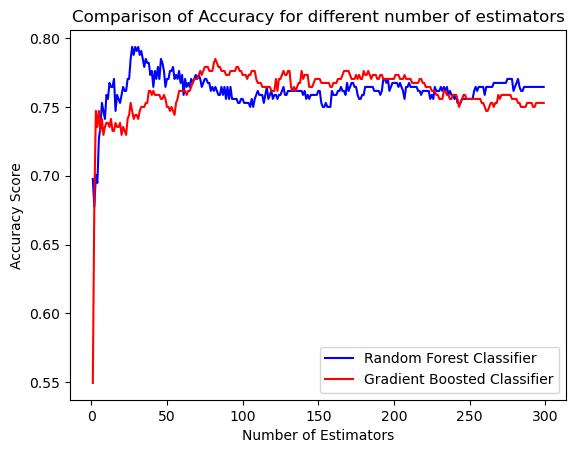

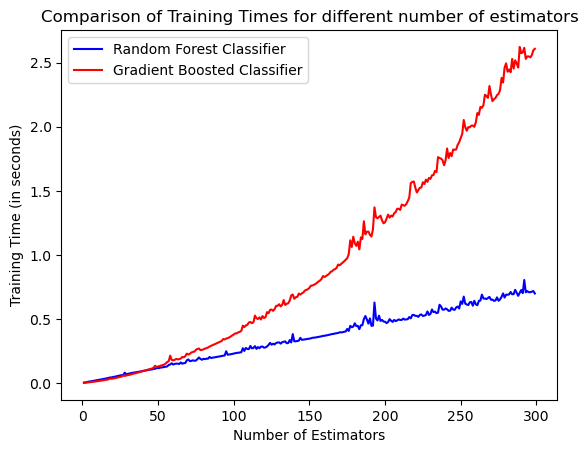

In [1214]:
rfacc_arr=[]
gbacc_arr=[]
rf_time=[]
gbc_time=[]
num_est=range(1,300)
for est in num_est:
    x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
    y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
    rf=RandomForestClassifier(est,7,20,1,True,'hard',30)
    t1=time.time()
    rf.fit(x_train_temp,y_train_temp)
    t2=time.time()
    rf_time.append(t2-t1)
    rfacc_arr.append(accuracy_score(y_wine_test,rf.predict(x_wine_test)))
    x_wtrain_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
    y_wtrain_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
    y_winetest_temp=np.where(y_wine_test[:, 0] == 1, 0, 1)
    y_winetrain_temp=np.where(y_wtrain_temp[:, 0] == 1, 0, 1)
    gbc=GradientBoostedClassifier(est,0.1,6,7,8,15)
    t1=time.time()
    gbc.fit(x_wtrain_temp,y_winetrain_temp)
    t2=time.time()
    gbc_time.append(t2-t1)
    out=gbc.predict(x_wine_test)
    out=(out>=0.5).astype(int)
    gbacc_arr.append(accuracy_score(y_winetest_temp,out))
plt.plot(num_est,rfacc_arr,label='Random Forest Classifier',color='blue')
plt.plot(num_est,gbacc_arr,label='Gradient Boosted Classifier',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy for different number of estimators')
plt.legend()
plt.show()
plt.plot(num_est,rf_time,label='Random Forest Classifier',color='blue')
plt.plot(num_est,gbc_time,label='Gradient Boosted Classifier',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (in seconds)')
plt.title('Comparison of Training Times for different number of estimators')
plt.legend()
plt.show()

### Comparison Between Random Forest Regressor with AdaBoost Regressor

#### The best performing AdaBoost Regressor model has a slightly higher R2-score than the best Random Forest Regressor model.

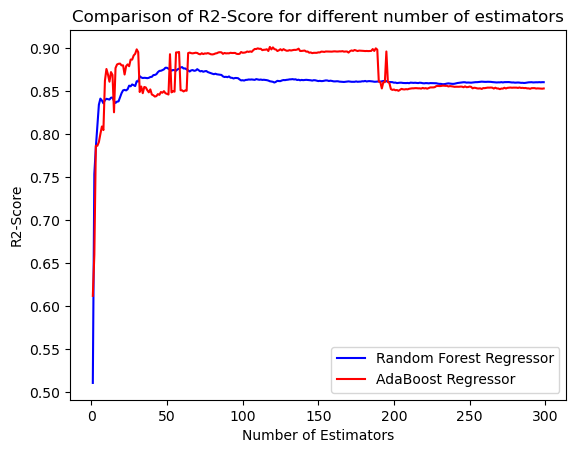

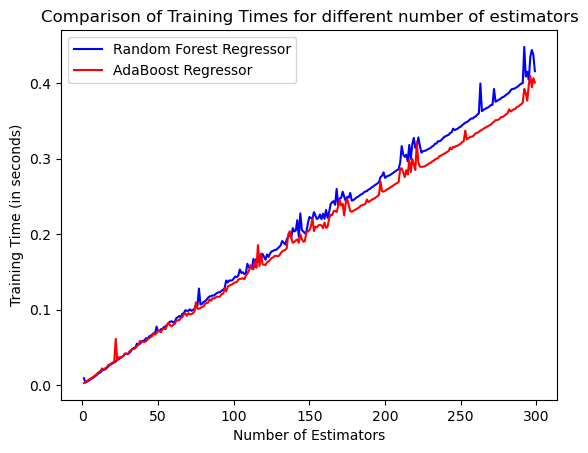

In [1210]:
rfacc_arr=[]
abacc_arr=[]
rf_time=[]
abc_time=[]
num_est=range(1,300)
for est in num_est:
    x_train_temp=np.concatenate((x_train,x_val), axis=0)
    y_train_temp=np.concatenate((y_train,y_val), axis=0)
    rfr=RandomForestRegressor(est,10,20,1,True,'hard',42)
    t1=time.time()
    rfr.fit(x_train_temp,y_train_temp)
    t2=time.time()
    rf_time.append(t2-t1)
    out=rfr.predict(x_test,x_val,y_val)
    rfacc_arr.append(r2_score(y_test,out))
    x_train_temp=np.concatenate((x_train,x_val), axis=0)
    y_train_temp=np.concatenate((y_train,y_val), axis=0)
    abr=AdaBoostRegressor(est,14)
    t1=time.time()
    abr.fit(x_train_temp,y_train_temp.squeeze())
    t2=time.time()
    abc_time.append(t2-t1)
    out=abr.predict(x_test)
    abacc_arr.append(r2_score(y_test,out))
plt.plot(num_est,rfacc_arr,label='Random Forest Regressor',color='blue')
plt.plot(num_est,abacc_arr,label='AdaBoost Regressor',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('R2-Score')
plt.title('Comparison of R2-Score for different number of estimators')
plt.legend()
plt.show()
plt.plot(num_est,rf_time,label='Random Forest Regressor',color='blue')
plt.plot(num_est,abc_time,label='AdaBoost Regressor',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (in seconds)')
plt.title('Comparison of Training Times for different number of estimators')
plt.legend()
plt.show()

### Comparison Between Random Forest Regressor with Gradient Boosted Regressor

#### The best performing Gradient Boosted Regressor model has a slightly higher R2-score than the best Random Forest Regressor model.

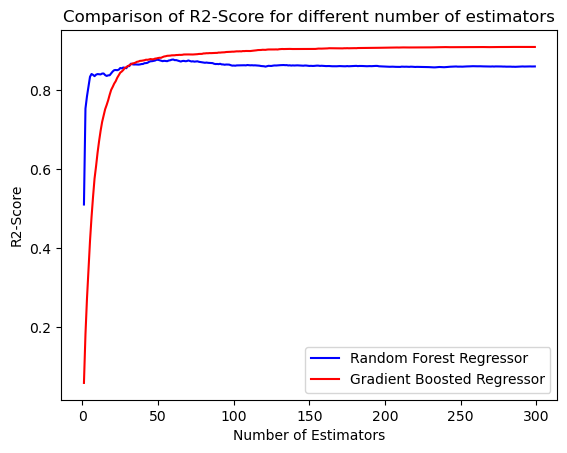

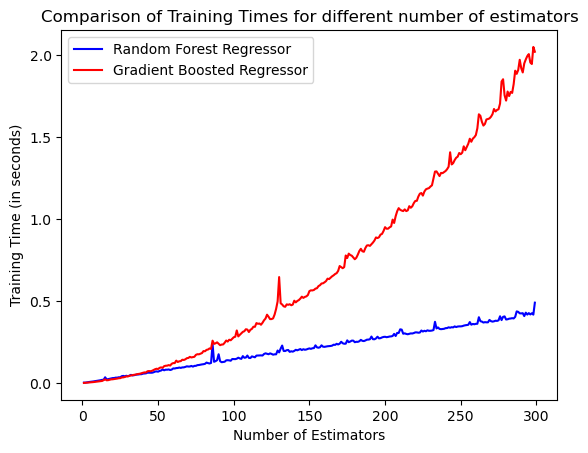

In [1212]:
rfacc_arr=[]
abacc_arr=[]
rf_time=[]
abc_time=[]
num_est=range(1,300)
for est in num_est:
    x_train_temp=np.concatenate((x_train,x_val), axis=0)
    y_train_temp=np.concatenate((y_train,y_val), axis=0)
    rfr=RandomForestRegressor(est,10,20,1,True,'hard',42)
    t1=time.time()
    rfr.fit(x_train_temp,y_train_temp)
    t2=time.time()
    rf_time.append(t2-t1)
    out=rfr.predict(x_test,x_val,y_val)
    rfacc_arr.append(r2_score(y_test,out))
    x_train_temp=np.concatenate((x_train,x_val), axis=0)
    y_train_temp=np.concatenate((y_train,y_val), axis=0)
    y_train_temp=y_train_temp.squeeze()
    gbr=GradientBoostedRegressor(est,0.1,5,10,6,117)
    t1=time.time()
    gbr.fit(x_train_temp,y_train_temp)
    t2=time.time()
    abc_time.append(t2-t1)
    out=gbr.predict(x_test)
    abacc_arr.append(r2_score(y_test,out))
plt.plot(num_est,rfacc_arr,label='Random Forest Regressor',color='blue')
plt.plot(num_est,abacc_arr,label='Gradient Boosted Regressor',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('R2-Score')
plt.title('Comparison of R2-Score for different number of estimators')
plt.legend()
plt.show()
plt.plot(num_est,rf_time,label='Random Forest Regressor',color='blue')
plt.plot(num_est,abc_time,label='Gradient Boosted Regressor',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (in seconds)')
plt.title('Comparison of Training Times for different number of estimators')
plt.legend()
plt.show()

### Analysis of mistakes of models for classification

Random Forest : Accuracy=0.7674418604651163, Precision=0.7883597883597884, Recall=0.7883597883597884
Confusion Matrix :- 
[[115  40]
 [ 40 149]]
Gradient Boosted : Accuracy=0.7732558139534884, Precision=0.8, Recall=0.783068783068783
Confusion Matrix :- 
[[118  37]
 [ 41 148]]
AdaBoost : Accuracy=0.7906976744186046, Precision=0.7969543147208121, Recall=0.8306878306878307
Confusion Matrix :- 
[[115  40]
 [ 32 157]]
(344, 11) (344, 11)
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count      48.000000         48.000000    48.000000       48.000000   
mean        8.154167          0.545833     0.273750        2.675000   
std         1.603581          0.193957     0.207525        1.237276   
min         6.000000          0.210000     0.000000        1.600000   
25%         7.000000          0.397500     0.097500        1.900000   
50%         7.900000          0.530000     0.235000        2.200000   
75%         8.675000          0.666250     0.402500        2.90000

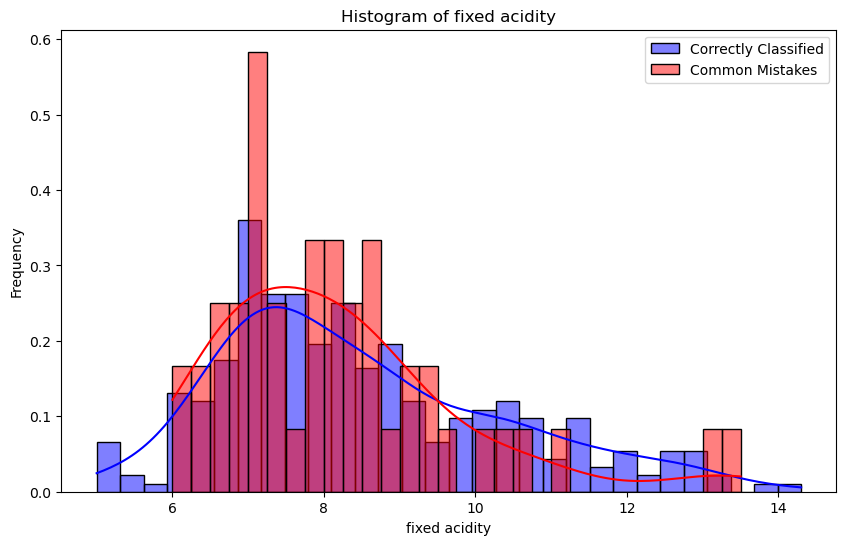

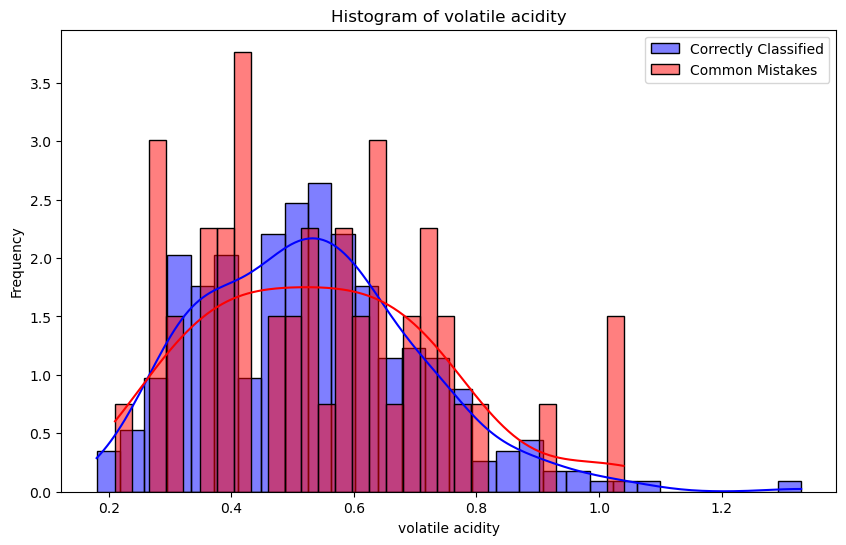

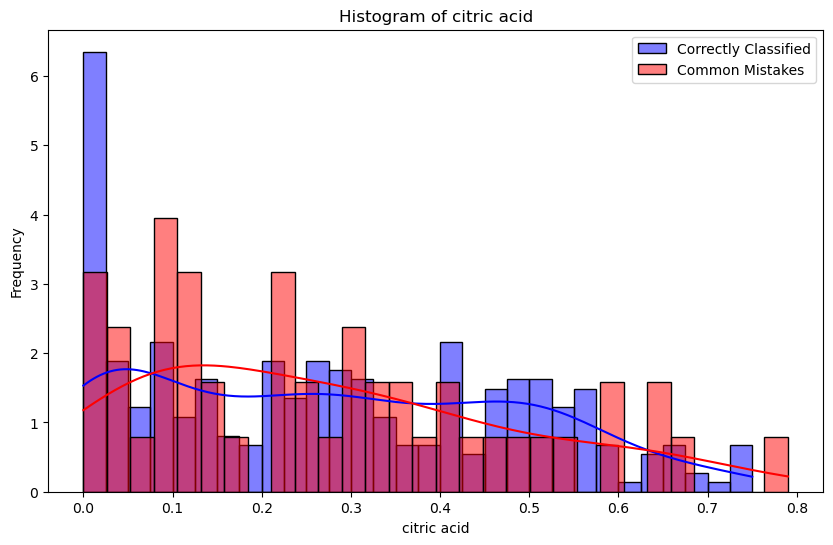

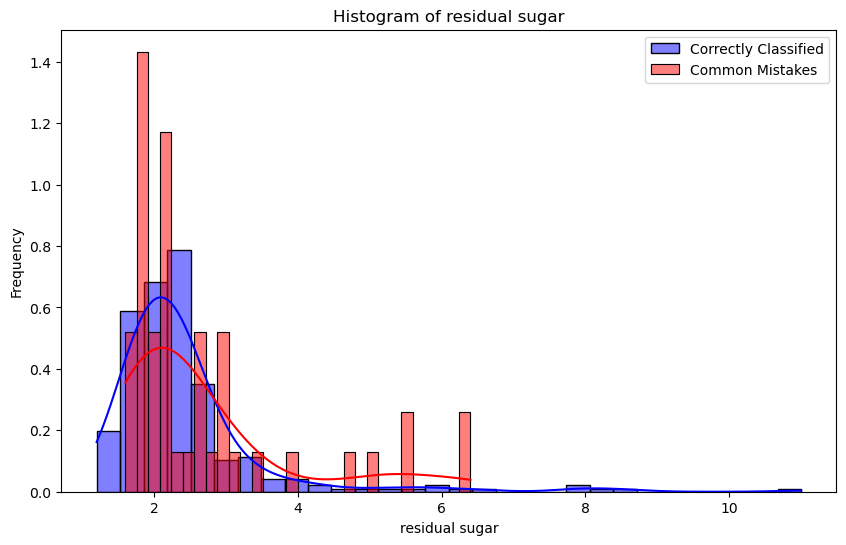

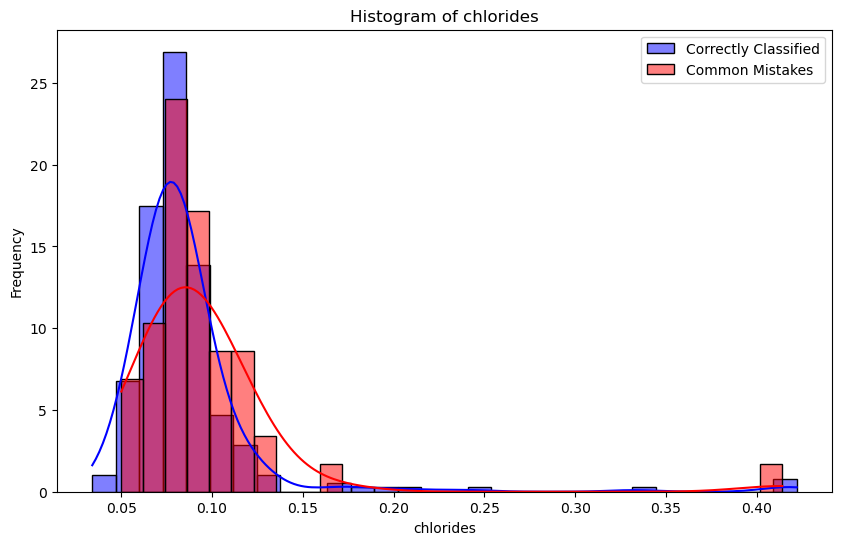

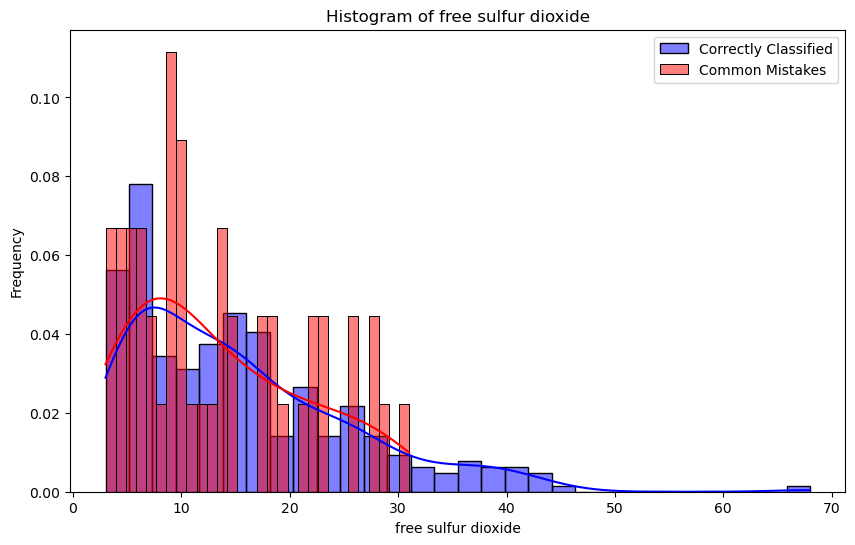

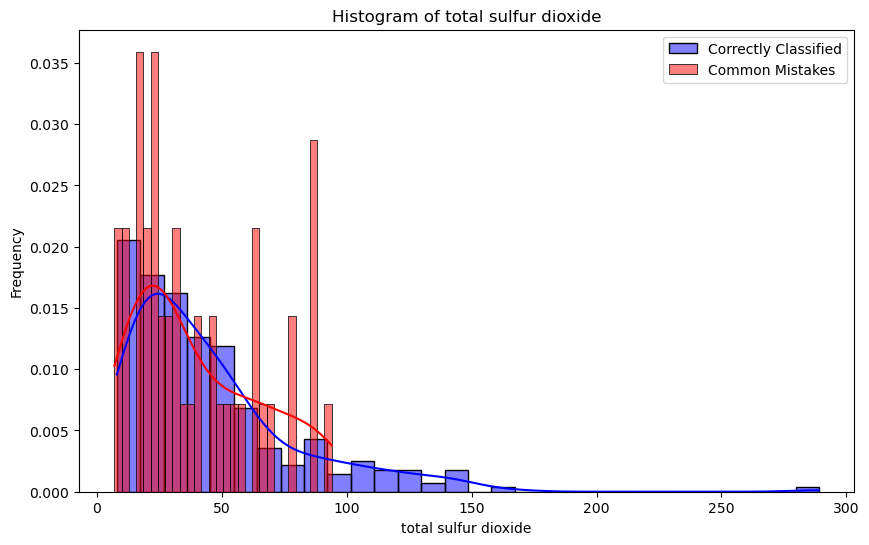

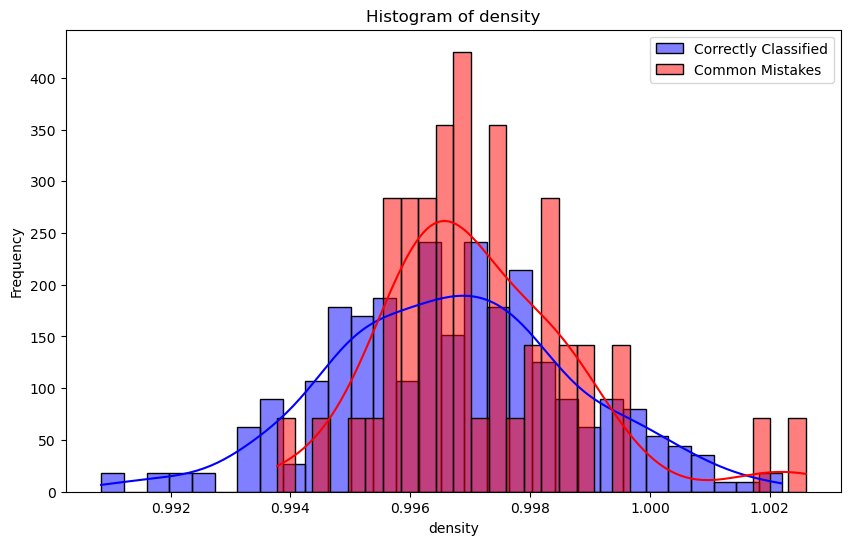

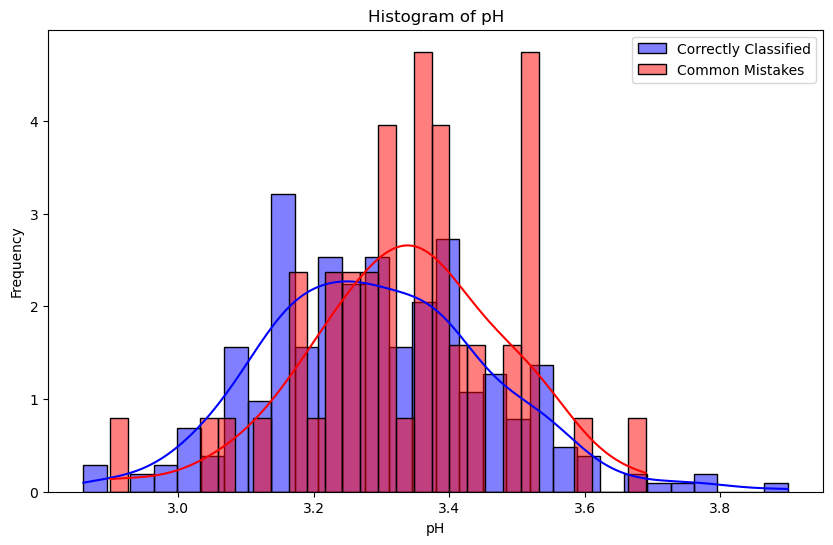

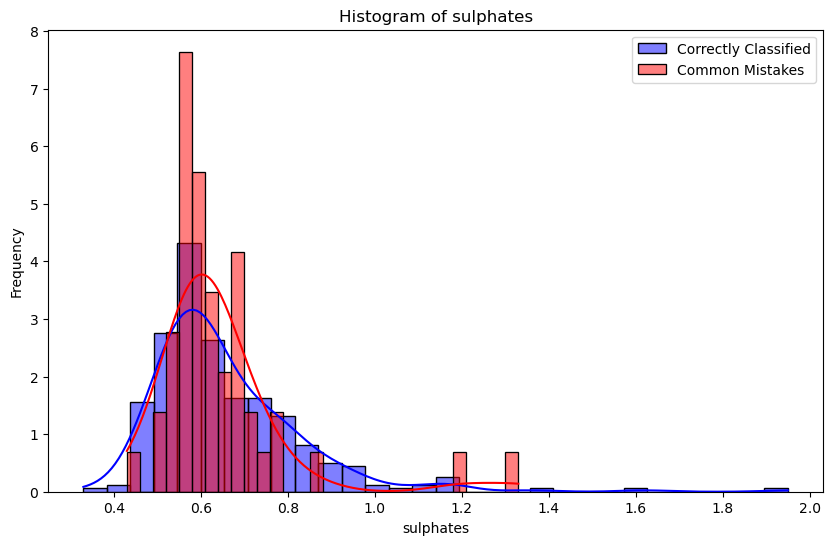

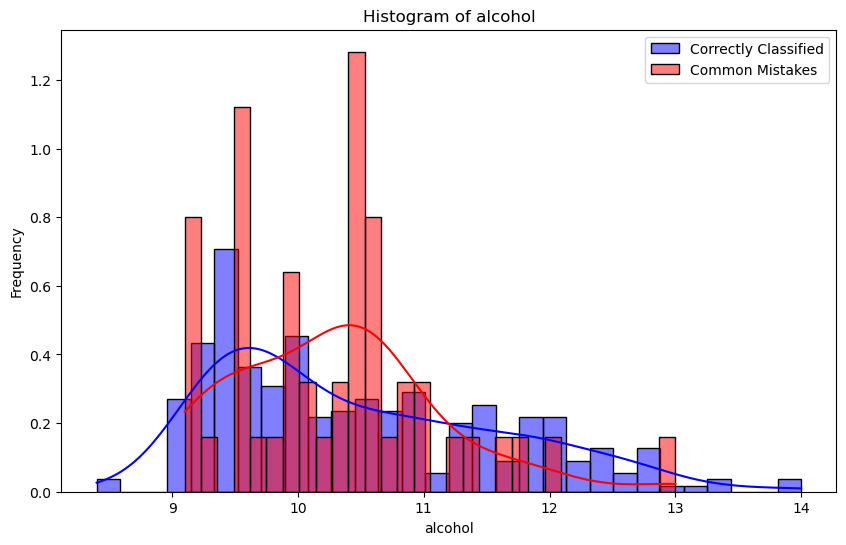

In [1441]:
# Random Forest
x_train_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_train_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
rf=RandomForestClassifier(200,7,20,1,True,'hard',30)
rf.fit(x_train_temp,y_train_temp)
out=rf.predict(x_wine_test)
acc=accuracy_score(y_wine_test,out)
pre=precision_score(y_wine_test.argmax(axis=1),out.argmax(axis=1))
rec=recall_score(y_wine_test.argmax(axis=1),out.argmax(axis=1))
print(f"Random Forest : Accuracy={acc}, Precision={pre}, Recall={rec}")
print("Confusion Matrix :- ")
print(confusion_matrix(y_wine_test.argmax(axis=1),out.argmax(axis=1)))
incorrect_indices_rf = np.where(y_wine_test.argmax(axis=1)!=out.argmax(axis=1))[0]
# Gradient Boosted
x_wtrain_temp=np.concatenate((x_wine_train,x_wine_val), axis=0)
y_wtrain_temp=np.concatenate((y_wine_train,y_wine_val), axis=0)
y_winetest_temp=np.where(y_wine_test[:, 0] == 1, 0, 1)
y_winetrain_temp=np.where(y_wtrain_temp[:, 0] == 1, 0, 1)
gbc=GradientBoostedClassifier(100,0.1,6,7,8,15)
gbc.fit(x_wtrain_temp,y_winetrain_temp)
out=gbc.predict(x_wine_test)
out=(out>=0.5).astype(int)
acc=accuracy_score(y_winetest_temp,out)
pre=precision_score(y_winetest_temp,out)
rec=recall_score(y_winetest_temp,out)
print(f"Gradient Boosted : Accuracy={acc}, Precision={pre}, Recall={rec}")
print("Confusion Matrix :- ")
print(confusion_matrix(y_winetest_temp,out))
incorrect_indices_gb = np.where(y_winetest_temp!=out)[0]
# AdaBoost
y_test_temp=np.where(y_wine_test[:, 0] == 1, -1, 1)
y_train_temp=np.where(y_train_temp[:, 0] == 1, -1, 1)
abc=AdaBoostClassifier(140,67)
abc.fit(x_train_temp,y_train_temp)
out=abc.predict(x_wine_test)
acc=accuracy_score(y_test_temp,out)
pre=precision_score(y_test_temp,out)
rec=recall_score(y_test_temp,out)
print(f"AdaBoost : Accuracy={acc}, Precision={pre}, Recall={rec}")
print("Confusion Matrix :- ")
print(confusion_matrix(y_test_temp,out))
incorrect_indices_ab = np.where(y_test_temp!=out)[0]
print(x_wine_test.shape,x_winetest_original.shape)
common_indices_wrong = np.intersect1d(incorrect_indices_rf, np.intersect1d(incorrect_indices_gb, incorrect_indices_ab))
df=x_winetest_original.iloc[common_indices_wrong]
print(df.describe())
df2=x_winetest_original.iloc[np.setdiff1d(np.arange(x_wine_test.shape[0]), common_indices_wrong)]
# If the histograms for a feature show similar distributions,
#  between correctly classified instances and common mistakes,
#  it suggests that the feature alone may not be a strong indicator of misclassification.
# If there are noticeable differences in the histograms, 
# it indicates that the feature might play a role in the misclassification patterns.
for feature in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df2[feature], bins=30, kde=True, label='Correctly Classified', color='blue',stat='density')
    sns.histplot(df[feature], bins=30, kde=True, label='Common Mistakes', color='red',stat='density')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

#### So, we can see that histograms for features - 'alcohol', 'pH', 'density' and 'chlorides' , have quite some difference in the distribution for correctly and incorrectly labelled samples.

#### Analysis using correlation between features within the common mistake samples and correctly labelled samples

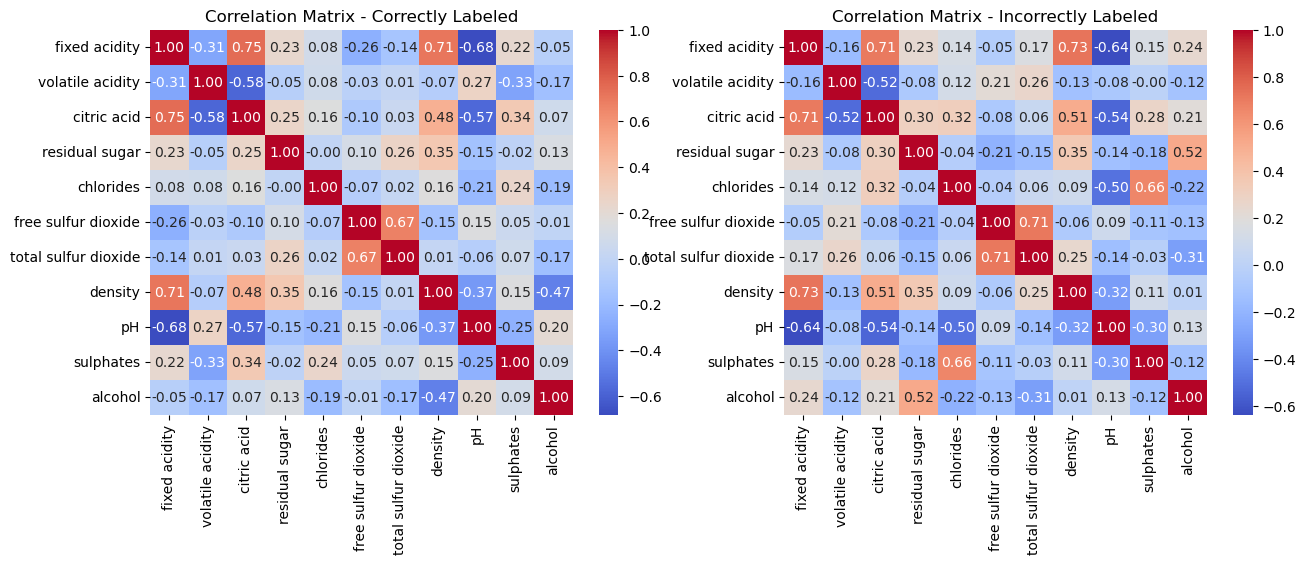

In [1442]:
cm1=df.corr()
cm2=df2.corr()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm2, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Matrix - Correctly Labeled')
sns.heatmap(cm1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Matrix - Incorrectly Labeled')
plt.show()

#### We can see that the rows corresponnding to features: alcohol, pH, density and chlorides are quite different for the 2 cases, showing why the model might have some problem to correctly predict labels for the given common wrongly predicted samples.